# Исследование продаж компьютерных игр

Мы работаем в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

In [1]:
!pip install missingno

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno

from scipy import stats as st

pd.set_option('display.max_columns', None)

## Откроем файл с данными и изучим общую информацию. 

Изучим общую информацию по набору данных.

In [2]:
df = pd.read_csv('/datasets/games.csv')

df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


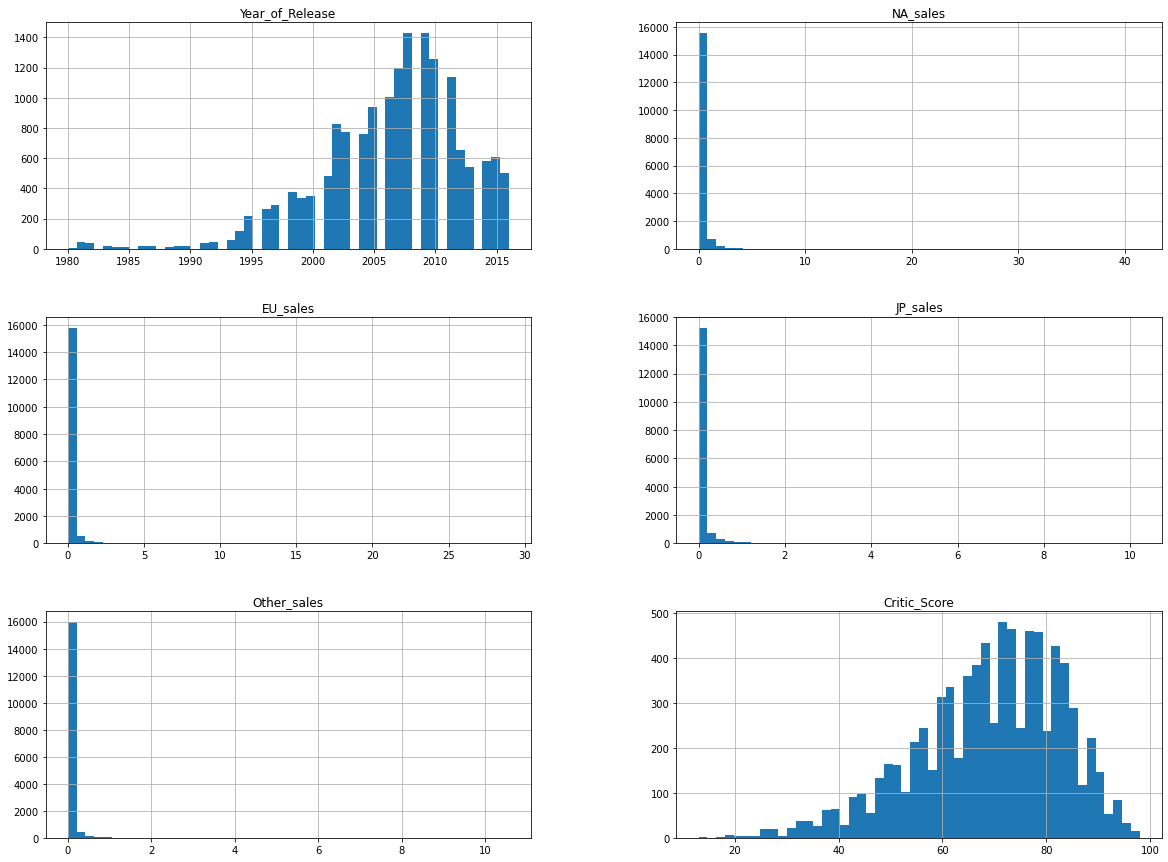

In [4]:
df.hist(figsize=(20, 15), bins=50)
plt.show()

**Вывод:** как мы заметили из первичного анализа, в дальнейшем этапе предобработки нам необходимо будет:
- привести названия столбцов к единому типу (в нижний регистр);
- разобраться с большим количеством пропусков в столбцах `critic_score`, `user_score` и `rating`;
- изменить тип столбца `year_of_release` на datetime, `user_score` на float;
- выяснить, присутствуют ли дубликаты в данных, как явные, так и неявные (в столбцах `platform`, `genre` и `rating`).

## Предобработка данных

### Переименование столбцов

Приведём названия всех столбцов к единому формату.


In [5]:
df.columns = df.columns.str.lower()

### Добавление дополнительных столбцов

Добавим новый столбец в датасет (он понадобится нам уже в следующем пункте "Изменение типов данных") - суммарные продажи во всех регионах `total_sales`:

In [6]:
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

### Изменение типов данных

Из сводки по нашему набору данных, мы видим, что дата выпуска игры `year_of_release` имеет тип данных `float64`, а также столбец `user_score` имеет тип данных `object`. Для дальнейшего анализа нам необходимо привести их к типам `datetime` и `float64`.

Поскольку в `year_of_release` присутствуют пропуски, нам придётся их отбросить для корректного приведения типа. Прежде чем избавиться от пропусков, изучим: не приведёт ли эта операция к искажению данных.

In [7]:
print(df[df['year_of_release'].isna()].count())
print()
print('Всего строк:', df.shape[0])

name               269
platform           269
year_of_release      0
genre              269
na_sales           269
eu_sales           269
jp_sales           269
other_sales        269
critic_score       154
user_score         175
rating             181
total_sales        269
dtype: int64

Всего строк: 16715


In [8]:
print('Доля строк с пропусками в "year_of_release"', 269/16715)

Доля строк с пропусками в "year_of_release" 0.01609332934489979


Изучим распределение по суммарным продажам у строк с пропущенными "year_of_release":

In [9]:
df[df['year_of_release'].isna()]['total_sales'].describe()

count    269.000000
mean       0.367732
std        0.613082
min        0.010000
25%        0.050000
50%        0.160000
75%        0.380000
max        5.240000
Name: total_sales, dtype: float64

Теперь изучим распределение по суммарным продажам у всего датасета:

In [10]:
df['total_sales'].describe()

count    16715.000000
mean         0.533396
std          1.548261
min          0.000000
25%          0.060000
50%          0.170000
75%          0.470000
max         82.540000
Name: total_sales, dtype: float64

Как мы видим, значения квартилей похожи. Различаются средние значения (в 1.5 раза) и стандартные отклонения (в 2.5 раза), а ещё максимальные значения (более чем в 16 раз!).

Оценим суммарные продажи по всему срезу данных с пропущенными "year_of_release" и какую долю они составляют от суммарных продаж по всему датасету:

In [11]:
print('Суммарные продажи с пропусками в "year_of_release":',
      df[df['year_of_release'].isna()]['total_sales'].sum())
print('Суммарные продажи по всему датасету:',
      df['total_sales'].sum())
print('Доля продаж:', df[df['year_of_release'].isna()]['total_sales'].sum() / df['total_sales'].sum())

Суммарные продажи с пропусками в "year_of_release": 98.91999999999999
Суммарные продажи по всему датасету: 8915.71
Доля продаж: 0.01109502215751746


**Обобщим:** всего строк с пропусками в "year_of_release" 1.6% от общего датасета, по описательным статистикам срез с пропусками похож на весь датасет, причём разброс значений у среза значительно меньше; в срезе присутствуют выбросы, но максимальные выбросы в 16 раз меньше таковых у всего датасета; суммарные продажи среза составляют 1.1% от суммарных продаж датасета. Исходя из всего вышеперечисленного, приходим к выводу: если мы избавимся от данного среза с пустыми значениями "year_of_release", это не приведёт к искажению данных и существенному смещению.

Избавляемся от пропусков и приводим к нужным типам:

In [12]:
print('Количество строк до удаления:', df.shape[0])
df = df.dropna(subset=['year_of_release'])
print('Количество строк после удаления:', df.shape[0])
df['year_of_release'] = df['year_of_release'].astype('int32')
df['year_of_release'] = pd.to_datetime(df['year_of_release'], format='%Y')
df['year_of_release'] = df['year_of_release'].dt.year

Количество строк до удаления: 16715
Количество строк после удаления: 16446


Поскольку в столбце `user_score` есть значения 'tbd', нам необходимо решить, что с ними делать, прежде чем привести столбец из текстового типа к числу с плавающей точкой.

Аббревиатура 'tbd' означает 'to be determined' ('подлежит уточнению'). Используется когда что-то ещё не решено или не известно. В нашем случае мы можем смело заменить значения tbd на NaN - смысл не изменится.

Так же, мы приведём пользовательскую оценку к 100-бальной - по аналогии с оценкой критиков.

In [13]:
df['user_score'] = df['user_score'].apply(lambda x: 'NaN' if x=='tbd' else x)
df = df.astype({'user_score':'float64'})
df['user_score'] = df['user_score']*10

### Обработка пропусков


Определим общее количество пропусков.

In [14]:
df.isna().sum()

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8463
user_score         8983
rating             6678
total_sales           0
dtype: int64

Изучим пропуски в датасете (отсортированном по годам выпуска игр) с помощью библиотеки missingno - она предоставляет крайне полезную и удобную визуализацию.

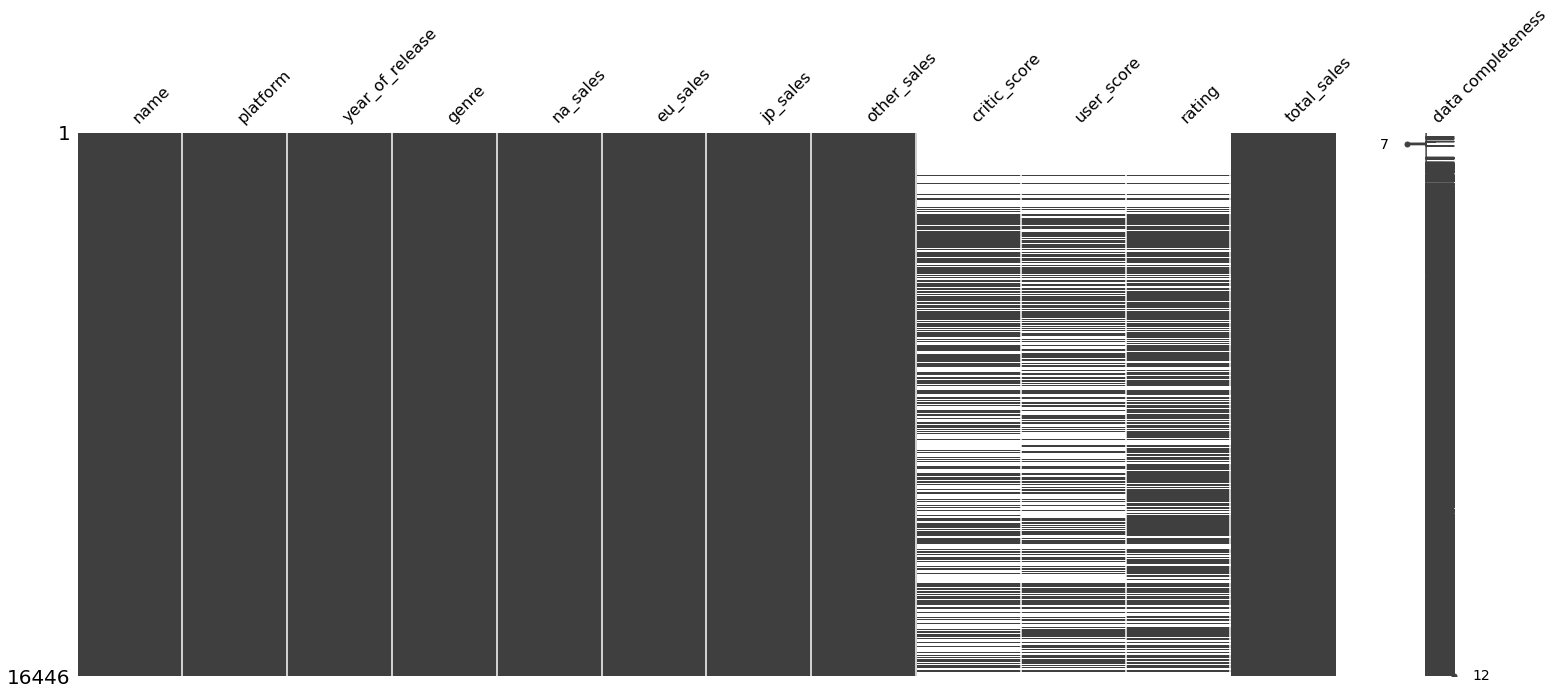

In [15]:
msno.matrix(df.sort_values(by='year_of_release'), labels=True)
plt.show()

Как видно из матрицы пропусков, игры выпущенные в начале запуска индустрии видеоигр не имеют данных о оценке критиков/пользователей и возрастном рейтинге. Это из-за того, возрастной рейтинг ESRB появился только в 1994 году и данные по средней оценке пользователей и критиков никто не собирал централизованно до популяризации интернета.

А в дальнейшем (примерно после ~2000 года), пропуски имеют случайный характер.
Оценим корреляцию у пропущенных значений с помощью тепловой карты библиотеки missingno.

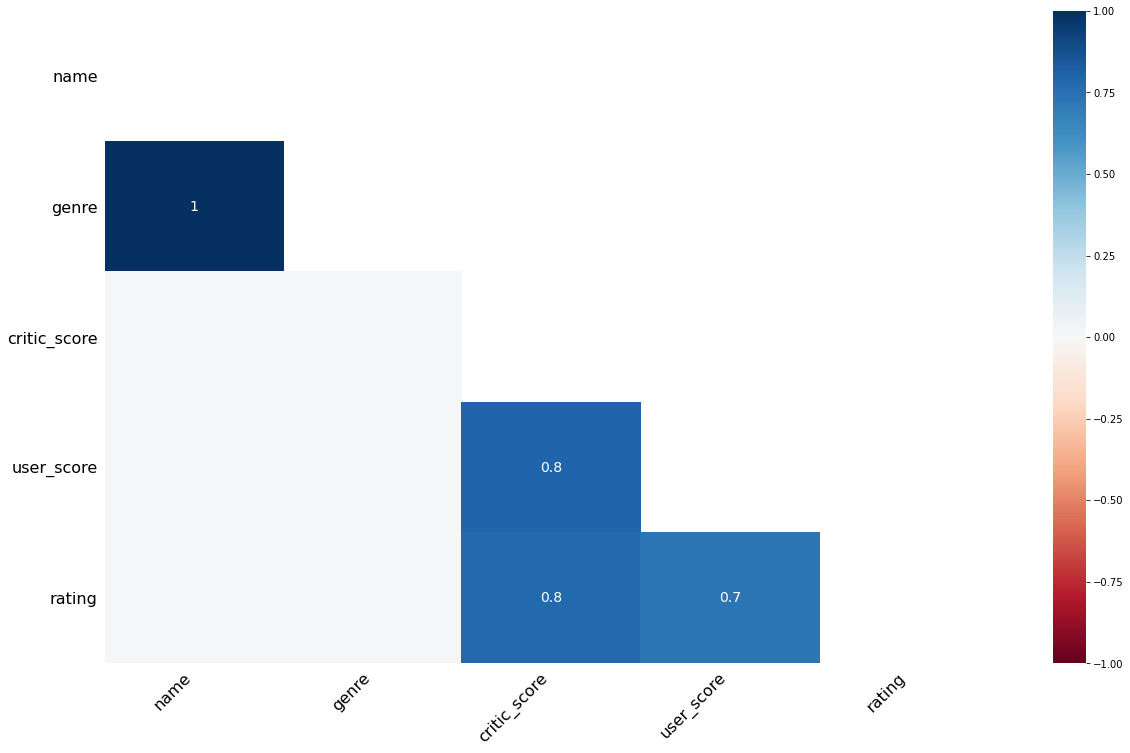

In [16]:
msno.heatmap(df)
plt.show()

Как мы видим, существует сильная корреляция между пропусками у столбцов оценки критиков/пользователей и рейтингом, т.е. во многих случаях, если отсутствует какое-то одно из значений этих столбцов, будут отсутствовать и остальные значения вышеназванных столбцов.

Видимо, пропуски в данных связаны с качеством открытых источников, откуда данные были взяты. Посмотрим, есть ли взаимосвязь между пропусками и платформой, либо жанром.

In [17]:
df[(df['rating'].isna()) & (df['year_of_release'] == 2016)].head(50)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
108,Pokemon Sun/Moon,3DS,2016,Role-Playing,2.98,1.45,2.26,0.45,NaN,NaN,NaN,7.14
1216,Ratchet & Clank (2016),PS4,2016,Platform,0.50,0.76,0.04,0.24,NaN,NaN,NaN,1.54
1275,Doom (2016),PS4,2016,Shooter,0.54,0.69,0.02,0.24,NaN,NaN,NaN,1.49
1466,Yokai Watch 3,3DS,2016,Action,0.00,0.00,1.33,0.00,NaN,NaN,NaN,1.33
1475,The Elder Scrolls V: Skyrim,PS4,2016,Role-Playing,0.48,0.59,0.04,0.21,NaN,NaN,NaN,1.32
2204,Rise of the Tomb Raider,PS4,2016,Adventure,0.23,0.53,0.04,0.14,NaN,NaN,NaN,0.94
2332,MLB 16: The Show,PS4,2016,Action,0.72,0.00,0.00,0.17,NaN,NaN,NaN,0.89
2694,Doom (2016),XOne,2016,Shooter,0.44,0.25,0.00,0.07,NaN,NaN,NaN,0.76
2768,The Elder Scrolls V: Skyrim,XOne,2016,Role-Playing,0.41,0.27,0.00,0.07,NaN,NaN,NaN,0.75
2973,Minecraft,WiiU,2016,Misc,0.28,0.17,0.18,0.04,NaN,NaN,NaN,0.67


Никакой взаимосвязи нет между платформой/жанром и пропусками. Наши пропуски в датасете обусловлены качеством открытых источников, из которых мы брали данные.

**Мы не будем заполнять пропуски в столбцах `critic_score` и `user_score`**, поскольку это сильно исказит смысл и характер данных. Очевидно, что между оценками пользователей и критиков и продажами видеоигр есть взаимосвязь, и заполнив пропущенные значения средними/медианными мы добавим много шума в исходные данные, затруднив тем самым дальнейший исследовательский анализ данных.

**А вот в столбце `rating` мы поставим вместо значений "NaN" заглушку "not rated by ESRB"**: мы сделаем так, поскольку в дальнейшем в проекте будут вопросы, касательно влияния рейтинга на продажи, а строк с пропусками в рейтинге практически треть от датасета (6678 строк!). Пропуски в рейтинге могут быть связаны и с тем, что игры были выпущены только в Японии/Европе и имеют свой собственный, внутренний рейтинг (а не американский ESRB). Для Японии это был бы рейтинг CERO, а для Европы - PEGI.

In [18]:
df['rating'] = df['rating'].fillna('not rated by ESRB')

Избавимся от игр с пропущенными именами и жанрами.

In [19]:
df = df.dropna(subset=['name', 'genre'])

### Поиск дубликатов

Оценим данные на наличие неявных дубликатов в столбцах `platform`, `genre` и `rating`.

In [20]:
sorted(df['platform'].unique())

['2600',
 '3DO',
 '3DS',
 'DC',
 'DS',
 'GB',
 'GBA',
 'GC',
 'GEN',
 'GG',
 'N64',
 'NES',
 'NG',
 'PC',
 'PCFX',
 'PS',
 'PS2',
 'PS3',
 'PS4',
 'PSP',
 'PSV',
 'SAT',
 'SCD',
 'SNES',
 'TG16',
 'WS',
 'Wii',
 'WiiU',
 'X360',
 'XB',
 'XOne']

In [21]:
sorted(df['genre'].unique())

['Action',
 'Adventure',
 'Fighting',
 'Misc',
 'Platform',
 'Puzzle',
 'Racing',
 'Role-Playing',
 'Shooter',
 'Simulation',
 'Sports',
 'Strategy']

In [22]:
df['rating'].unique()

array(['E', 'not rated by ESRB', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC',
       'RP'], dtype=object)

Поищем неявные дубликаты по паре "название"-"платформа":

In [23]:
df[df.duplicated(subset=['name', 'platform'])].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.0,0.13,0.02,0.10,83.0,85.0,T,1.25
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.0,0.06,0.00,0.02,82.0,85.0,T,0.08
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.00,0.00,83.0,55.0,E,0.01


Взглянем подробнее на дублирующиеся строки:

In [24]:
display(df[(df['name']=='Madden NFL 13') & (df['platform']=='PS3')])
display(df[(df['name']=='Need for Speed: Most Wanted') & (df['platform']=='X360')])
display(df[(df['name']=='Need for Speed: Most Wanted') & (df['platform']=='PC')])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,55.0,E,2.56
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,55.0,E,0.01


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1190,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83.0,85.0,T,1.56
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83.0,85.0,T,1.25


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
5972,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.0,0.04,82.0,85.0,T,0.29
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.00,0.06,0.0,0.02,82.0,85.0,T,0.08


С "NFS Most Wanted" для PC и Xbox 360 ситуация следующая: это перезапуски игры от разных разработчиков. А с "Madden NFL 13" всё не так ясно - скорее всего, на европейский рынок было выпущено какое-то дополнительное отличающееся издание игры. В любом случае, данные дубликаты трогать не будем.

Проверим на явные дубликаты:

In [25]:
df.duplicated().sum()

0

---
**Вывод:** мы завершили этап предобработки данных, в ходе которого мы
- привели названия всех столбцов к единому формату;
- изменили тип данных столбца `year_of_release` на datetime и `user_score` на float;
- удалили срез данных с пропусками в `year_of_release`;
- заменили все значения `user_score` с tbd на NaN, поскольку это не меняет общего смысла данных;
- изучили характер пропусков и выяснили, что они обусловлены качеством открытых источников, откуда были взяты исходные данные;
- приняли решение не заполнять пропуски в столбцах `critic_score`, `user_score`, поскольку это исказило бы общее качество данных;
- поставили заглушку в столбец `rating`;
- осуществили поиск явных и неявных дубликатов;
- добавили новый столбец суммарных продаж - `total_sales`.

Можно переходить к этапу исследовательского анализа данных.


## Исследовательский анализ данных

### Сколько игр выпускалось в разные годы

Посмотрим, сколько игр выпускалось в разные годы. Оценим, за какие периоды важны данные.

Предварительно, подготовим временный датасет, из которого уберём дубликаты по паре "Имя"-"Год выпуска", чтобы избавиться от строк с выпусками игр на разных платформах.

In [26]:
df_temp=df.drop_duplicates(subset=['name', 'year_of_release'], keep='first')

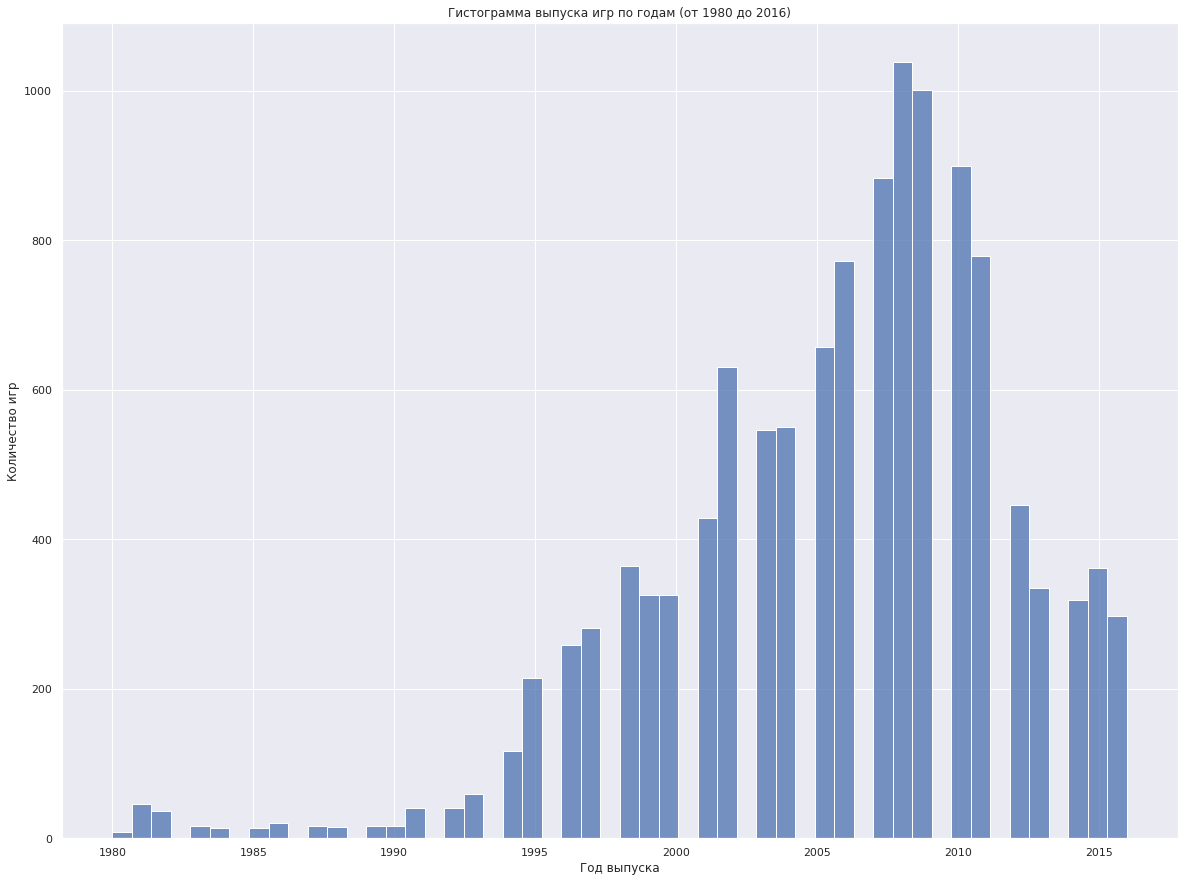

In [27]:
sns.set(rc={"figure.figsize":(20, 15)})
sns.histplot(data=df_temp, x="year_of_release")
plt.title('Гистограмма выпуска игр по годам (от 1980 до 2016)')
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр')
plt.show()

Как мы видим, с 1980 по 1990 год видеоигры были не настолько популярны - было небольшое количество платформ и в индустрию не вкладывалось большое количество денег. Начиная с 1990 года по 2000 года индустрия переживает свой расцвет - появление бОльшего количества платформ за счёт удешевления чипов и микросхем (что позволяет выпускать за относительно небольшие деньги приставки) - выпуск бОльшего количества игр для этих платформ, вливание денег в индустрию. 2000-2008 года - "золотой век" игр - стремительный рост, большие продажи, в индустрию вливается много денег. Всё это было прервано финансовым кризисом 2008 года, после которого индустрию ждал спад. Сперва постепенный, небольшой, но уже через 4 года (в 2012) было выпущено более чем в 2 раза меньше игр по сравнению с пиковым 2008ым. Начиная с 2015 года ситуация стабилизировалась и наметился небольшой рост (мы не оцениваем 2016 год, поскольку данные по нему неполные).

Для анализа популярности игр нам понадобятся данные за последний период (с 2012 года) со спадом и начинающимся ростом, т.к. он отражает текущее состояние дел.

### Как менялись продажи по платформам

Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. Определим, за какой характерный срок появляются новые и исчезают старые платформы.

Отберём первые 18 платформ, которые лидируют по суммарным продажам за всю историю индустрии; построим графики суммарных продаж по годам с помощью сводных таблиц:

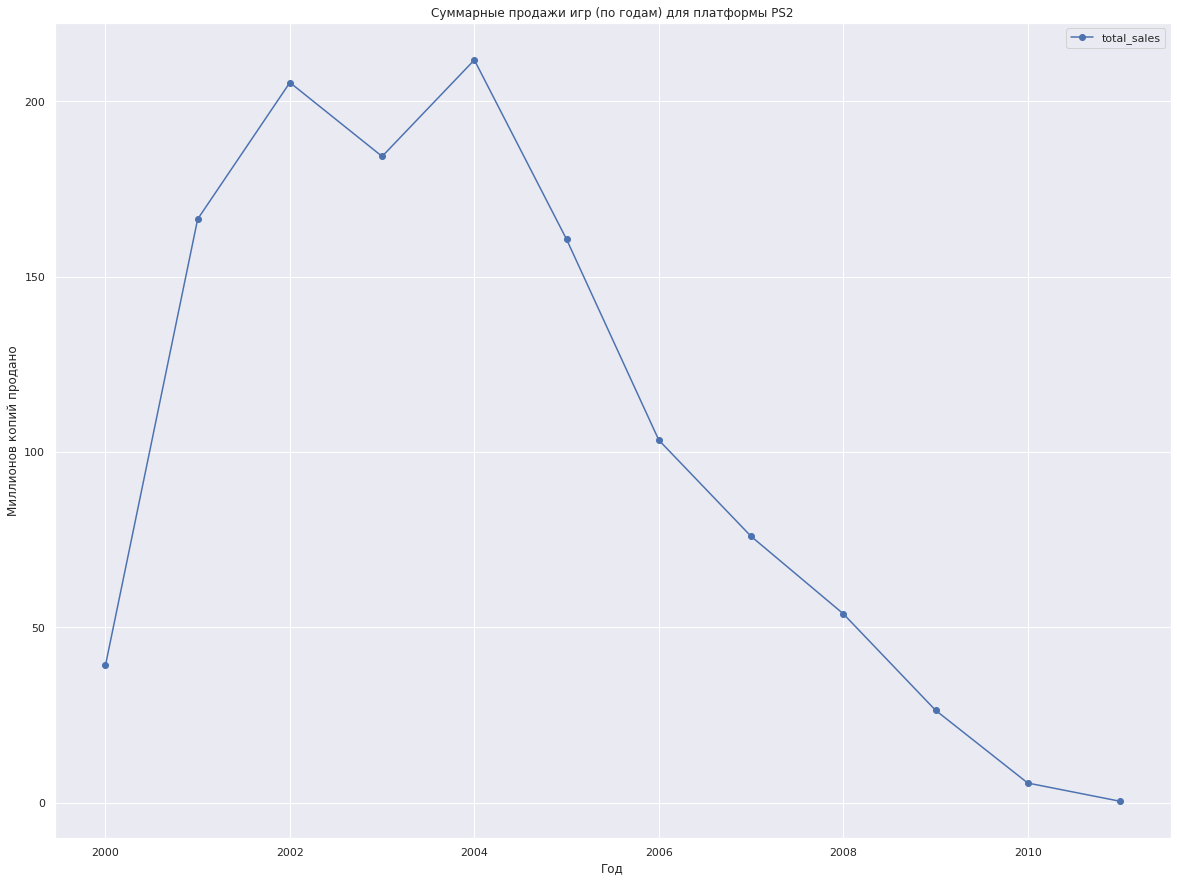

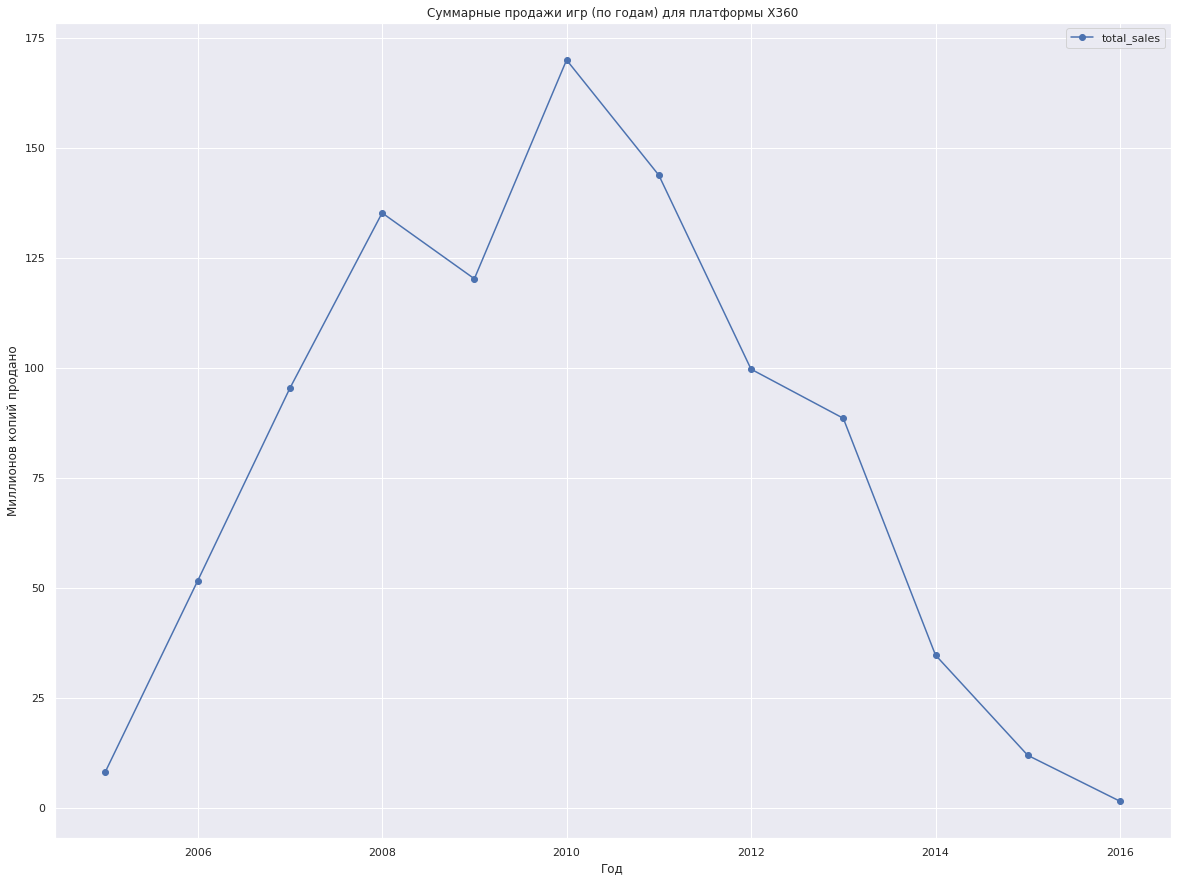

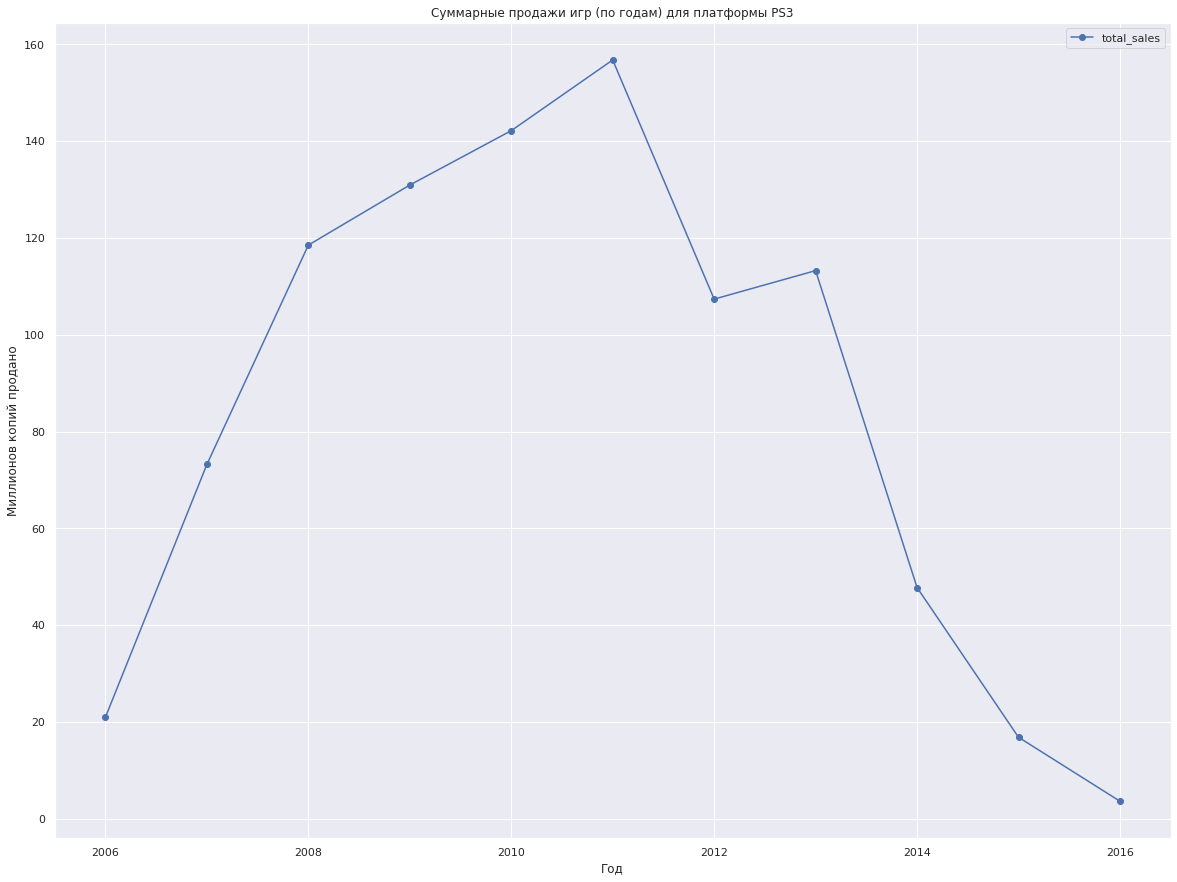

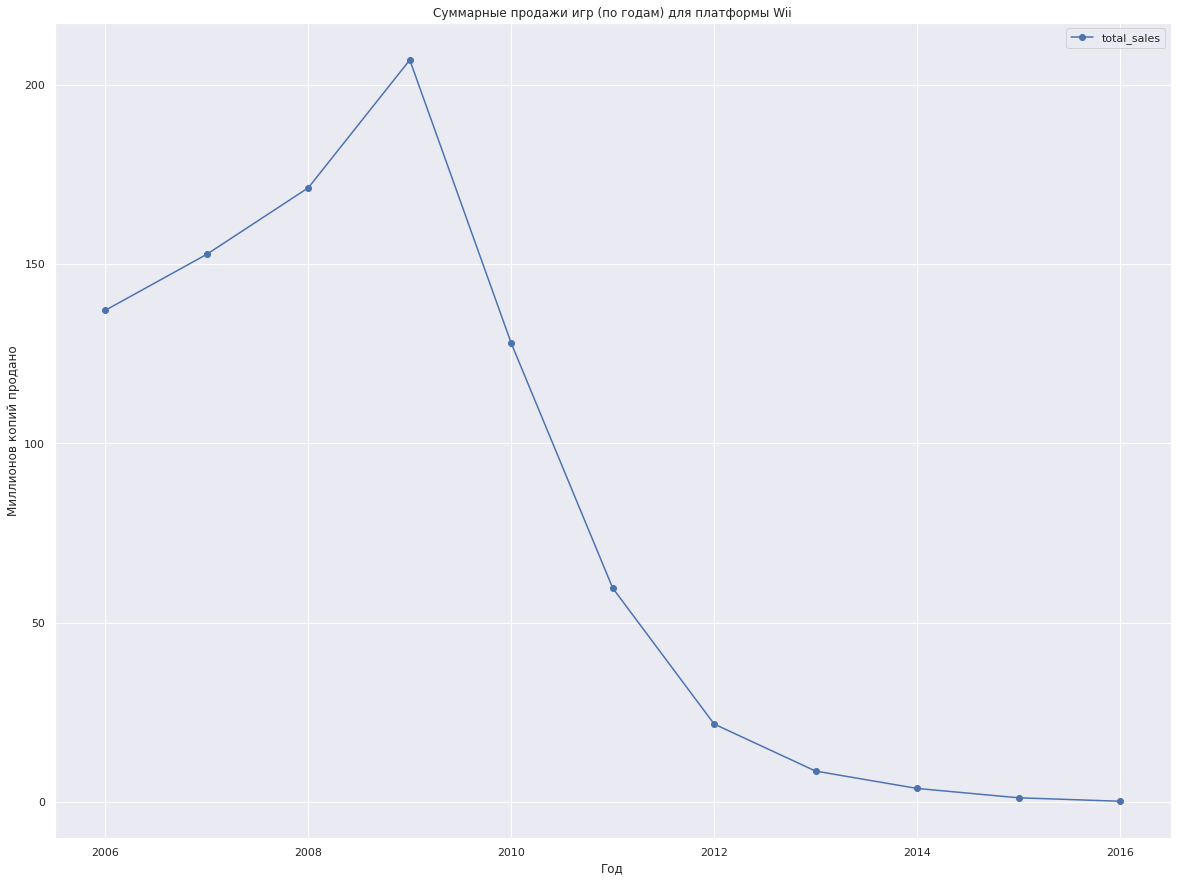

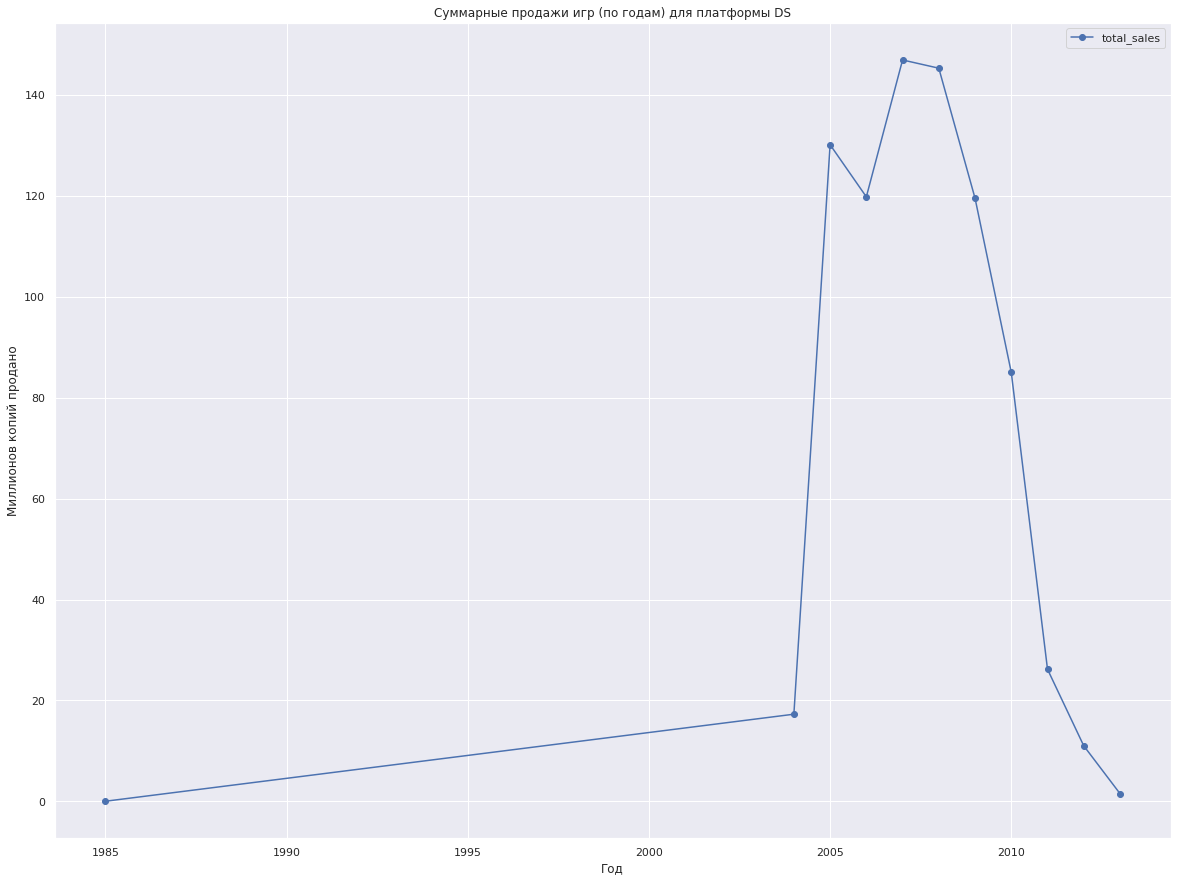

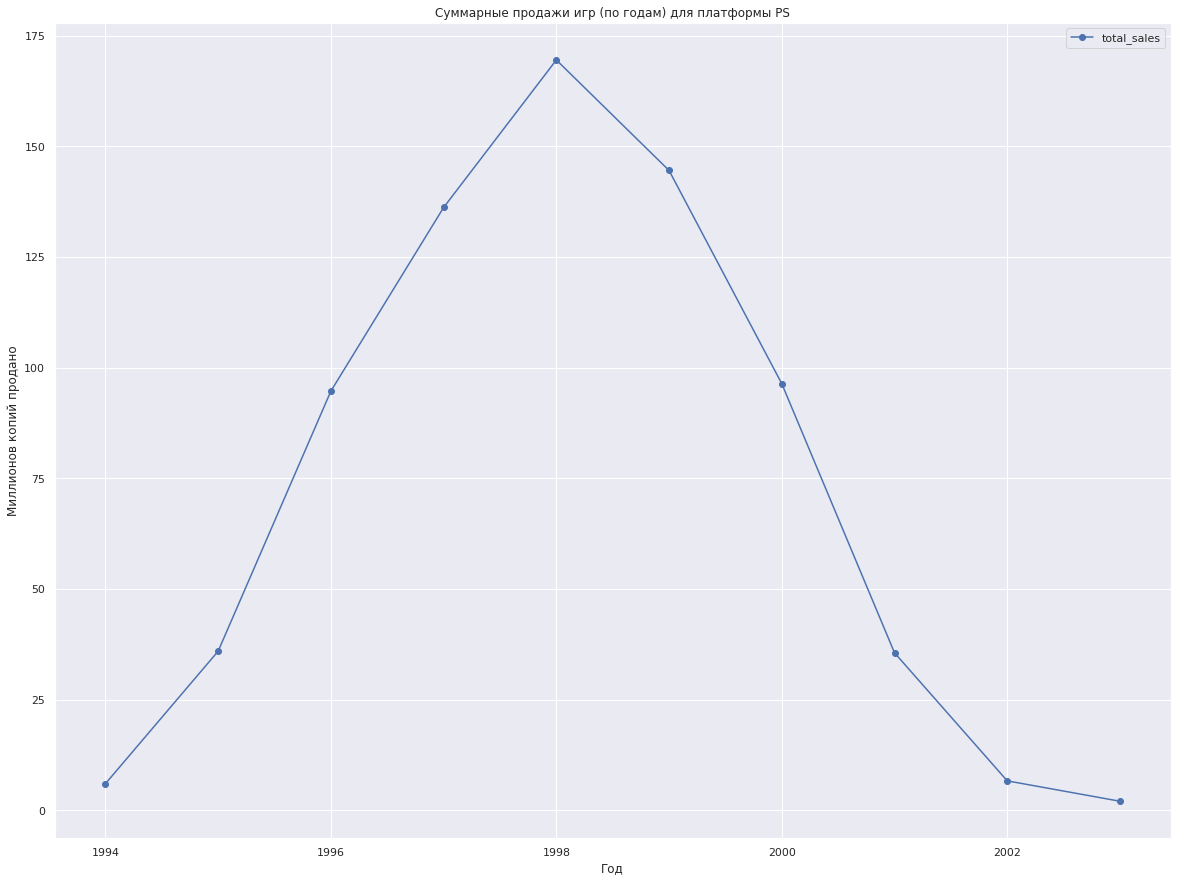

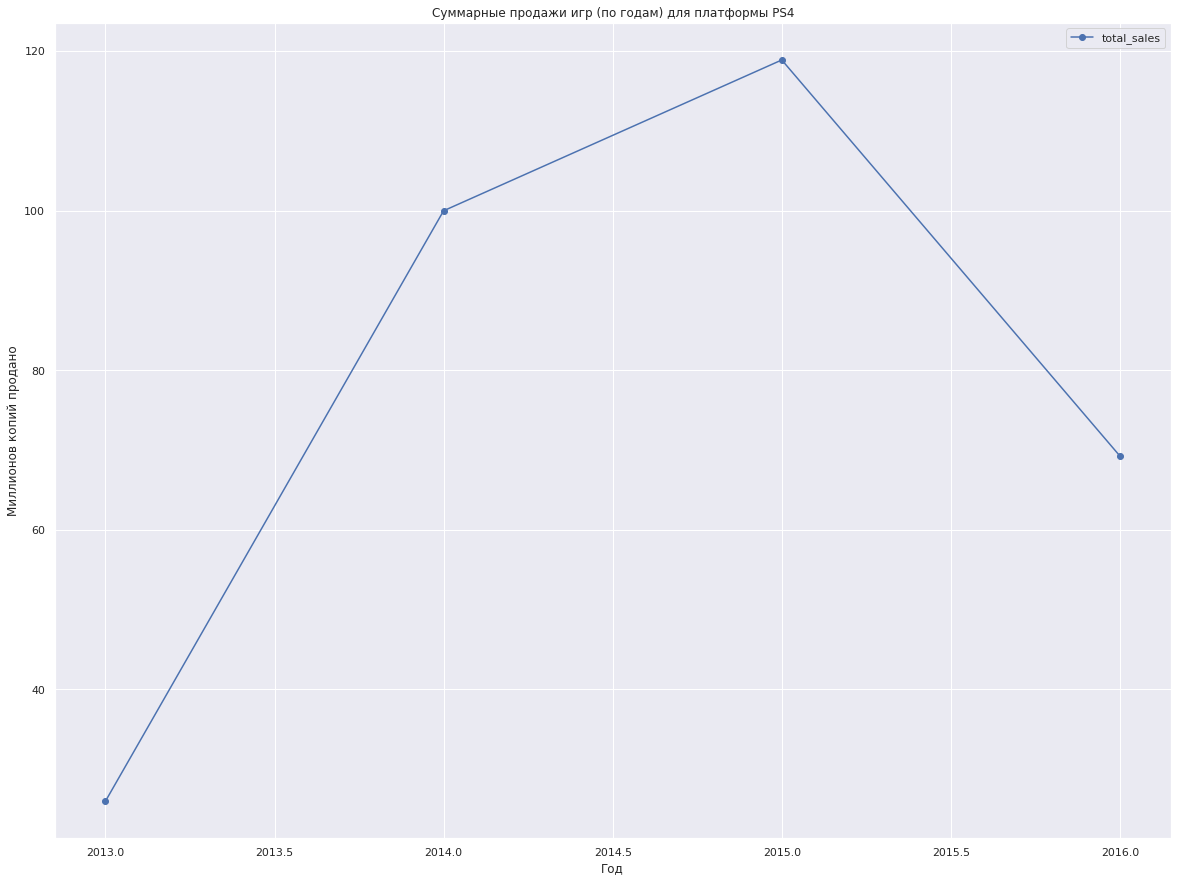

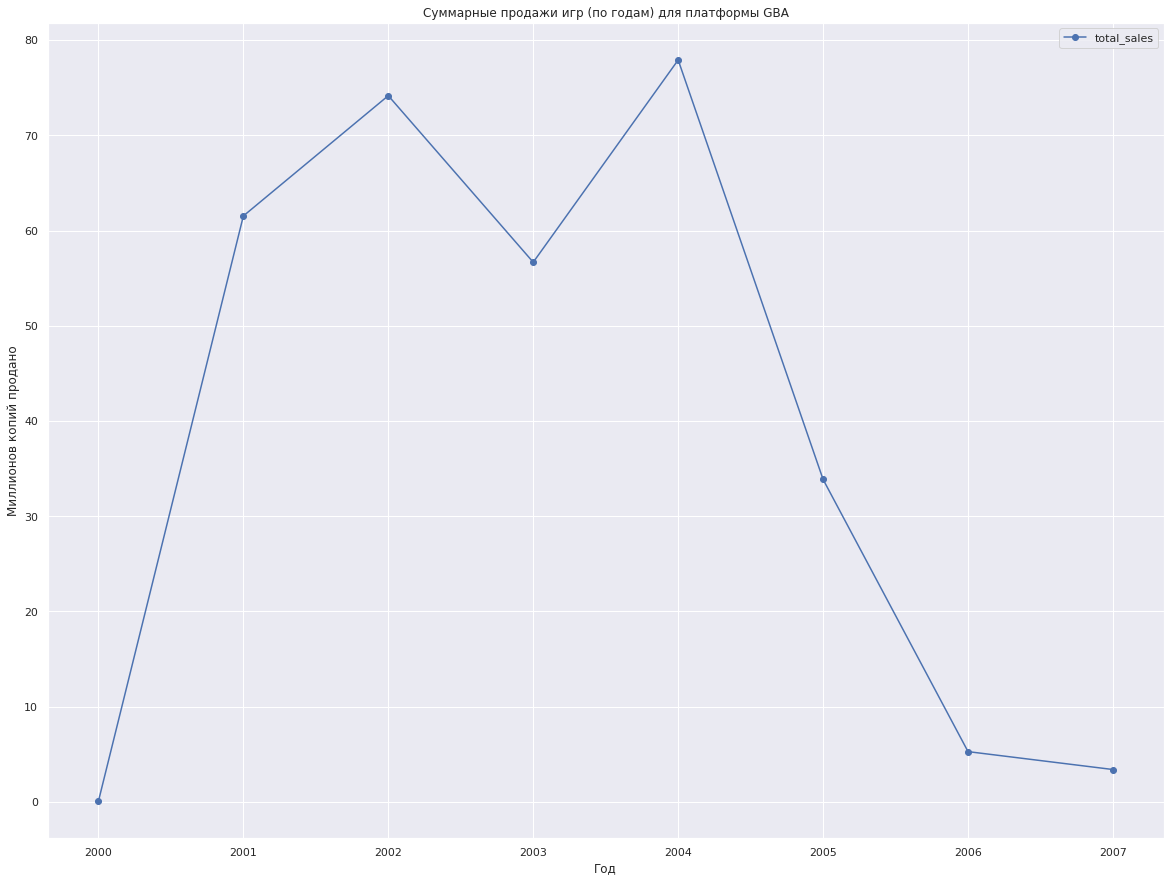

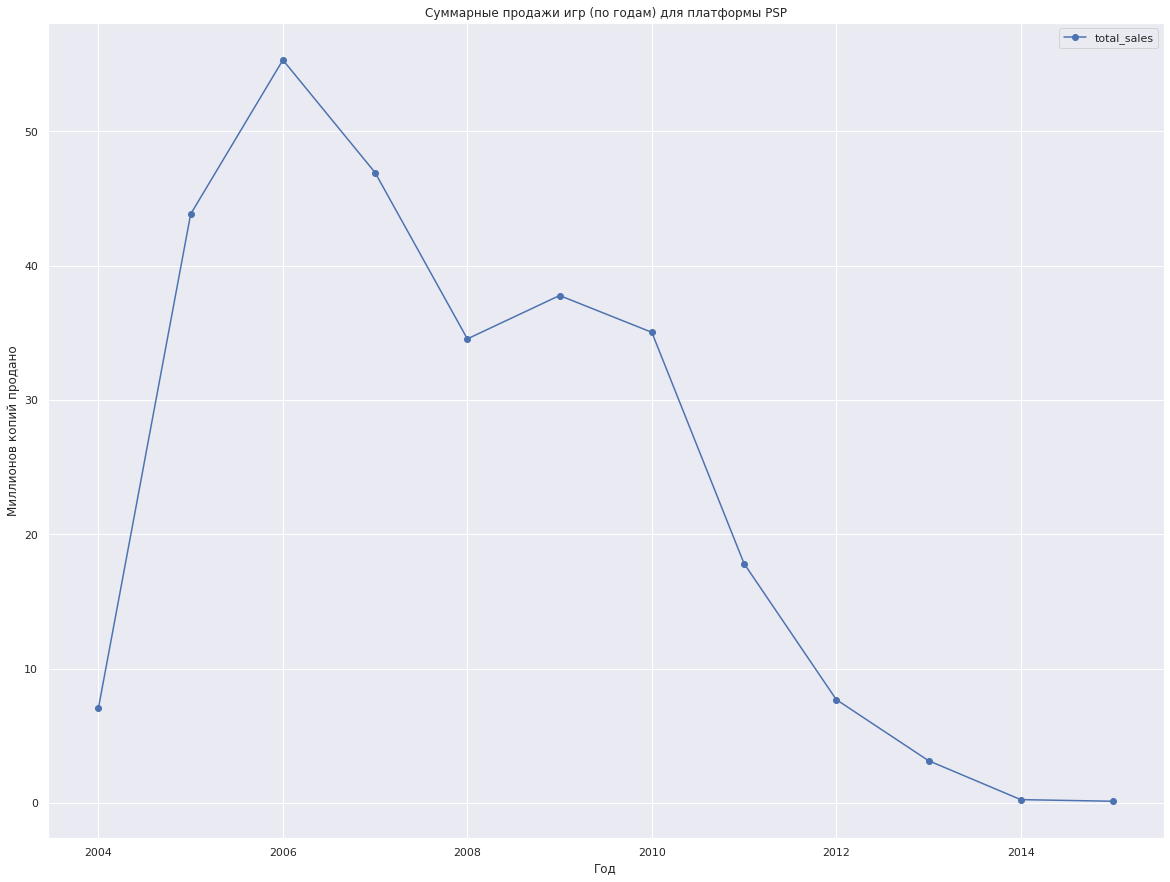

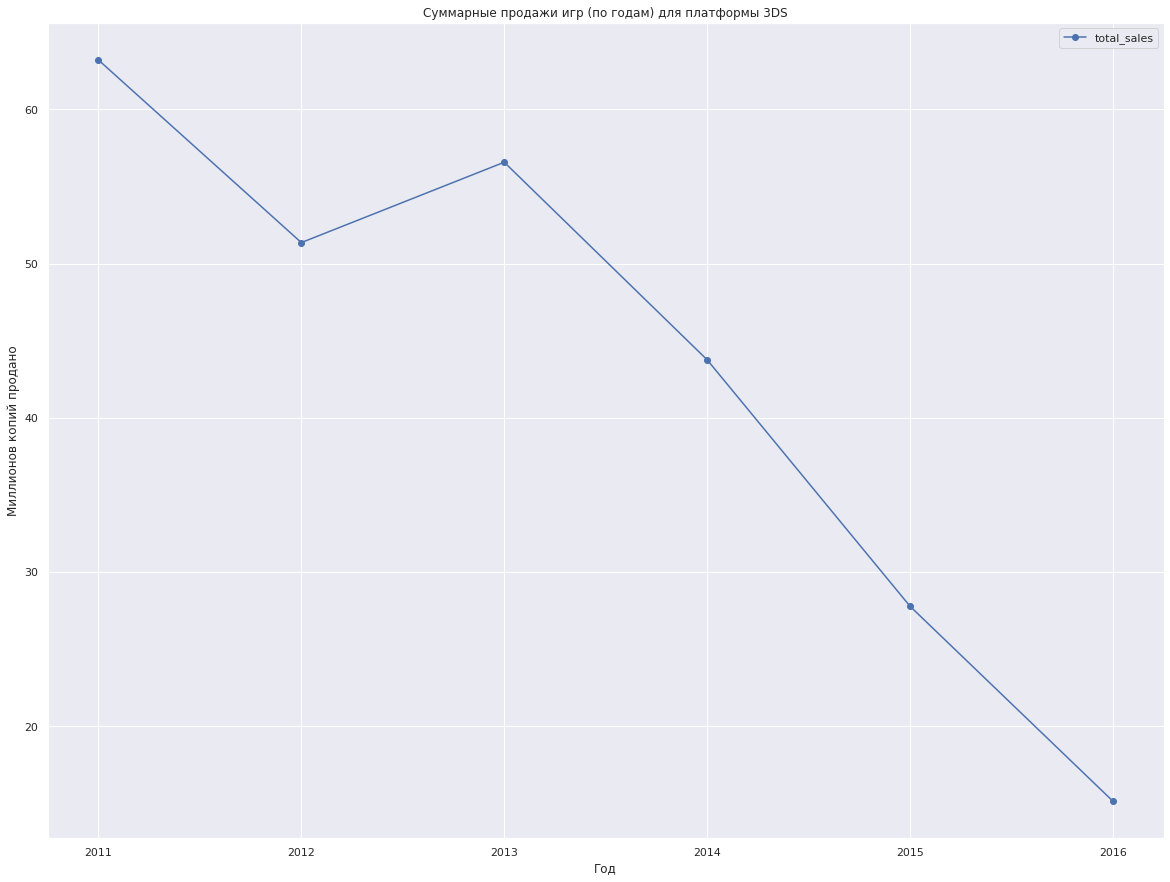

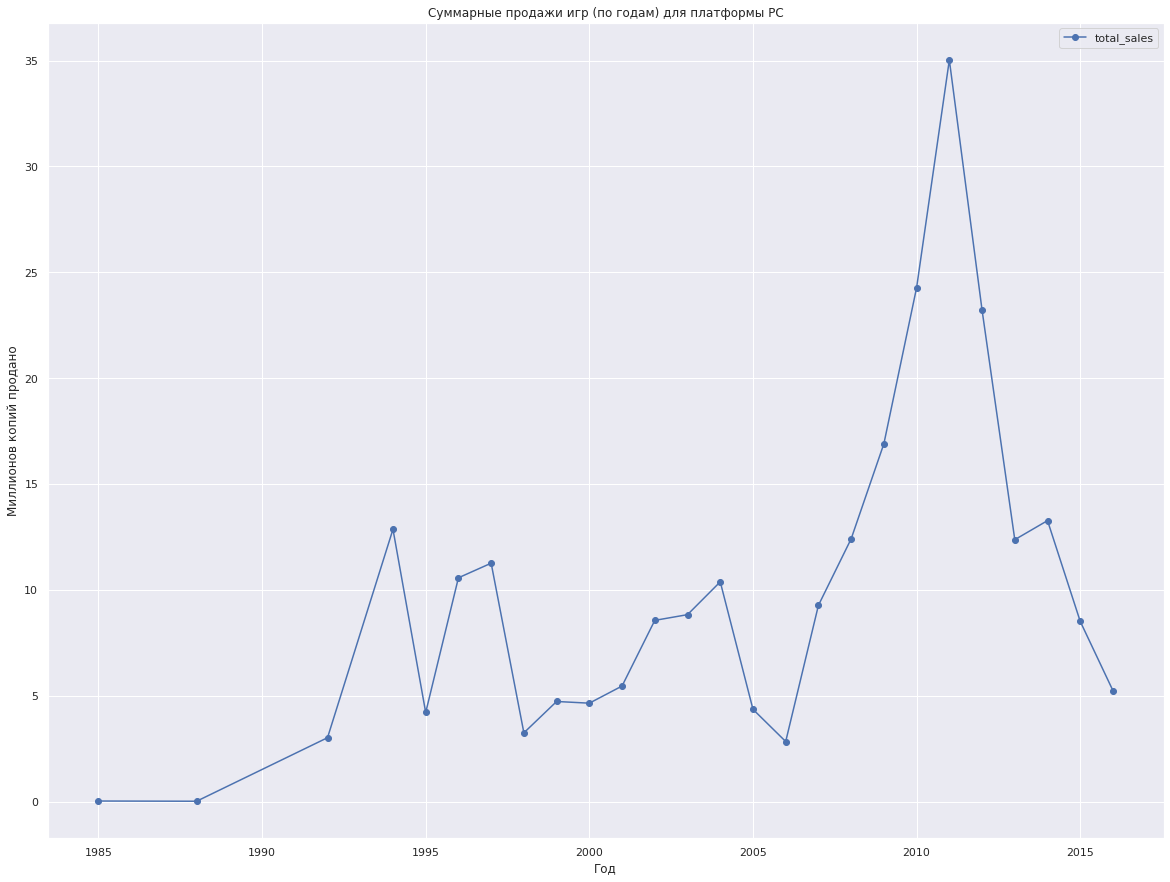

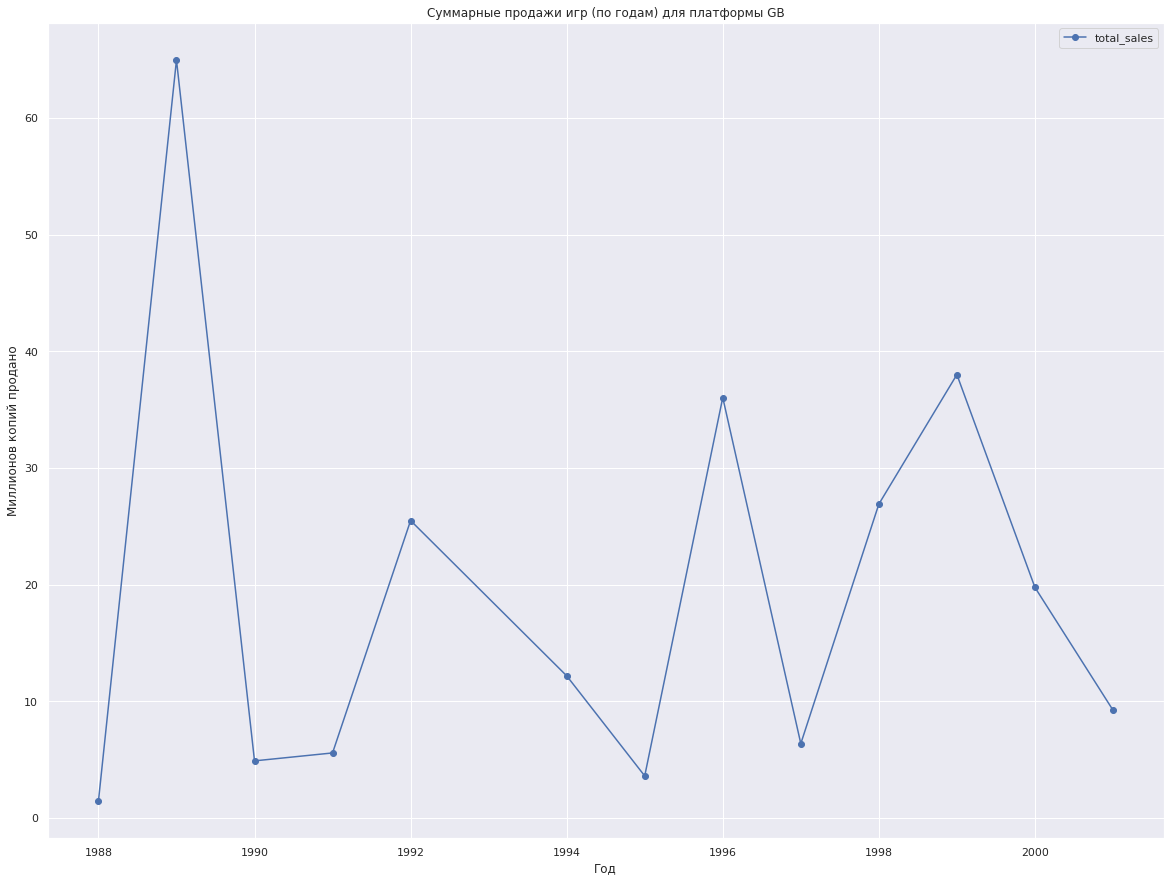

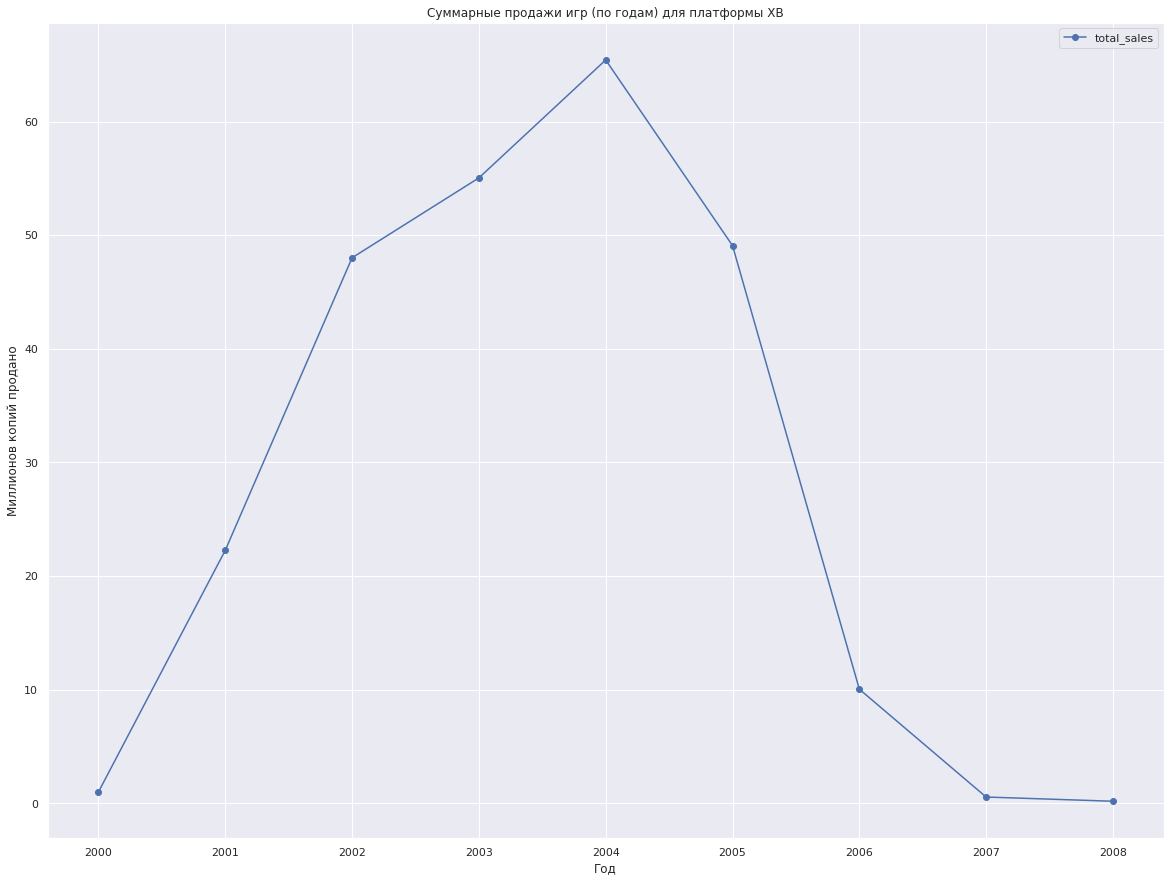

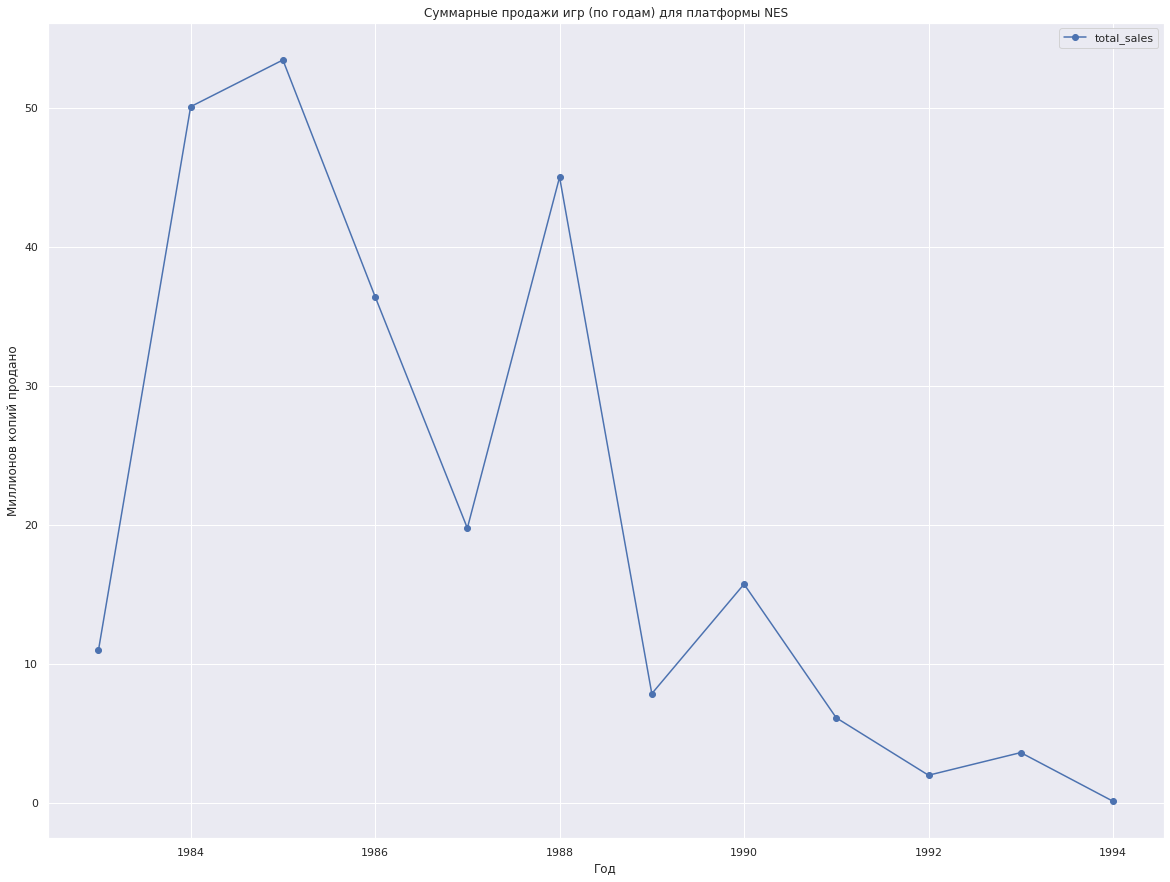

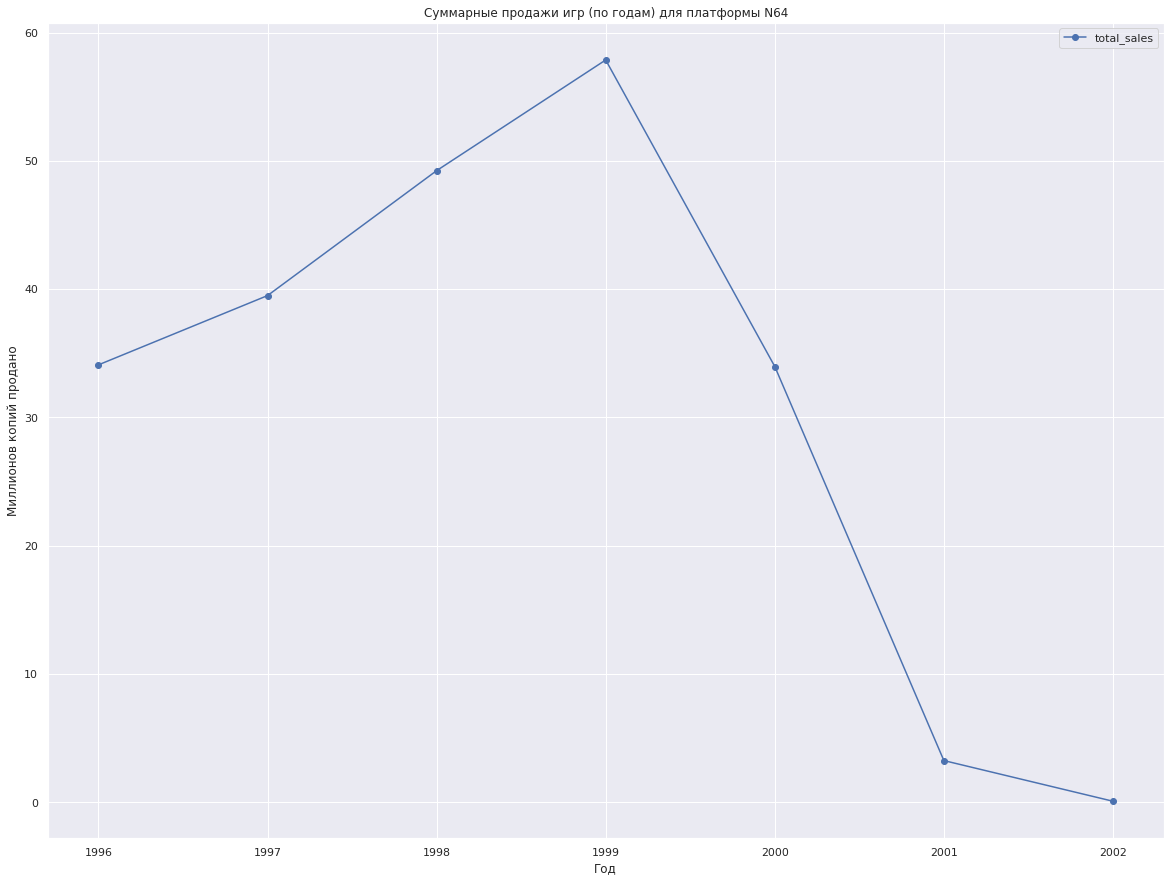

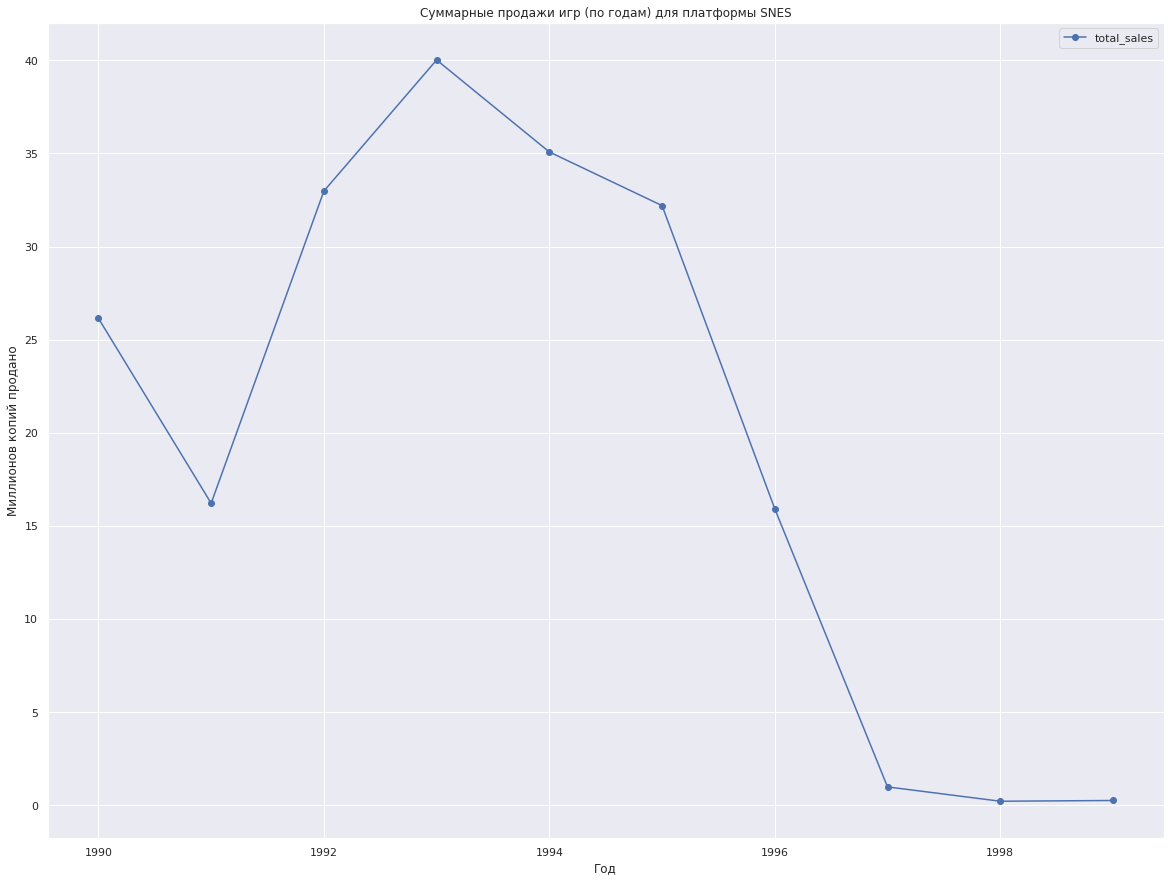

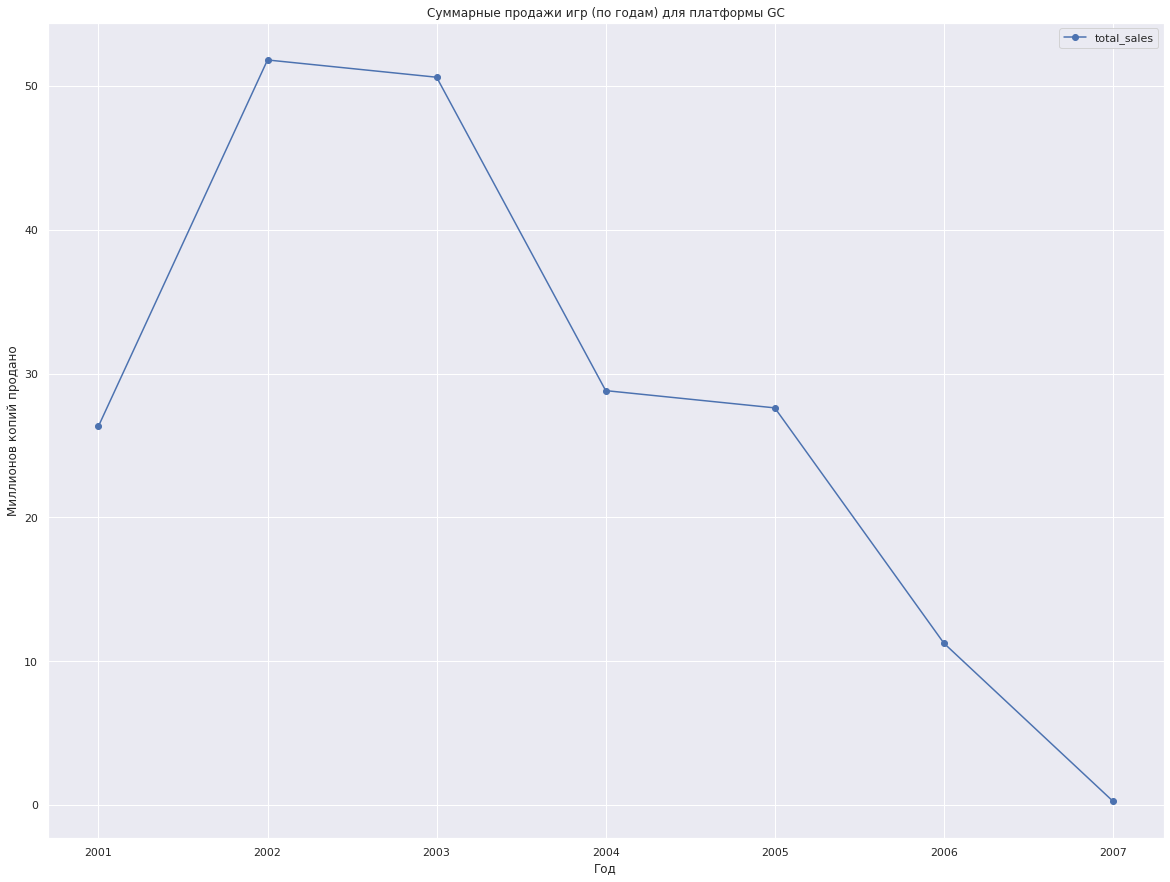

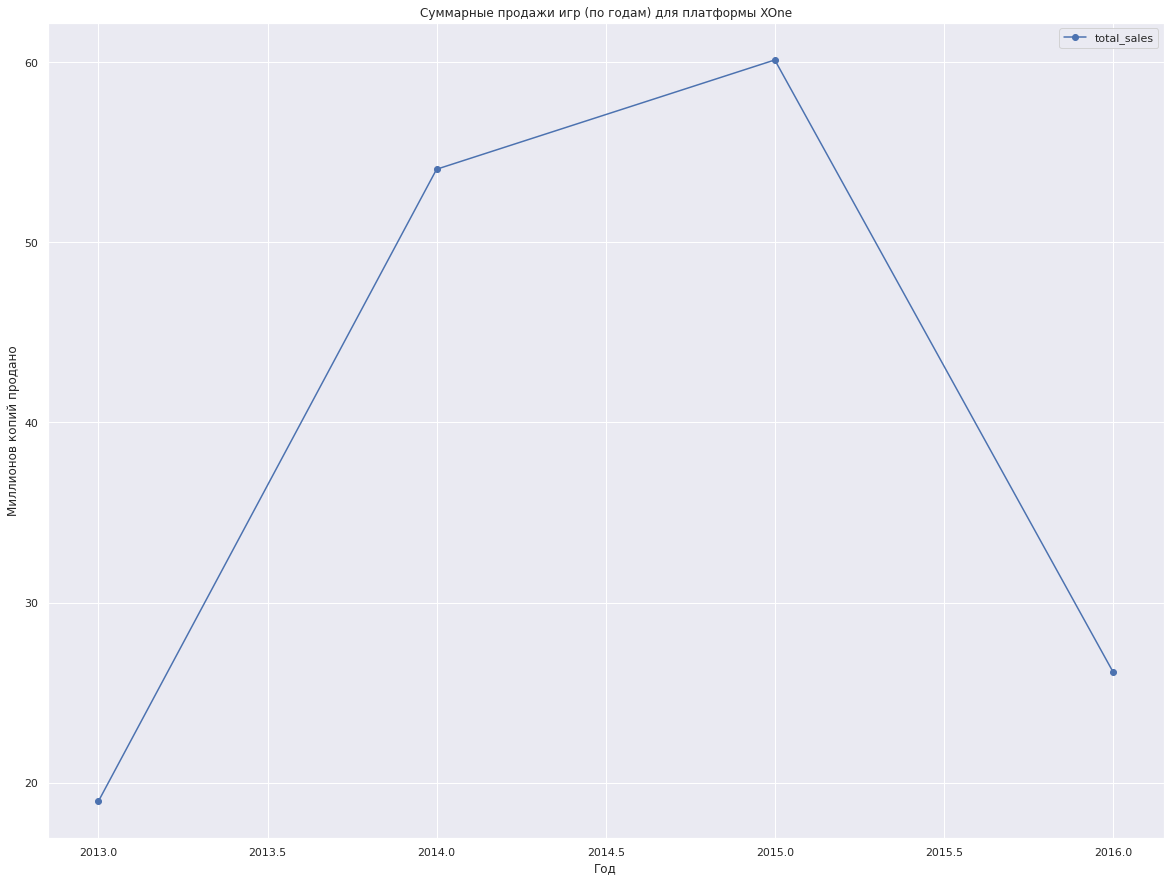

In [28]:
platforms = (
    df
    .pivot_table(index=['platform'], values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=False)
    .index.values.tolist()[:18])

for platform in platforms:
    platform_pivot = (
        df[df['platform'] == platform]
        .pivot_table(index=['year_of_release'], values='total_sales', aggfunc='sum')
    )
    platform_pivot.plot(
        style='o-',
        use_index=True,
        y='total_sales',
        figsize=(20,15),
        grid=True)
    plt.title(f'Суммарные продажи игр (по годам) для платформы {platform}')
    plt.xlabel('Год')
    plt.ylabel('Миллионов копий продано')
    plt.show()

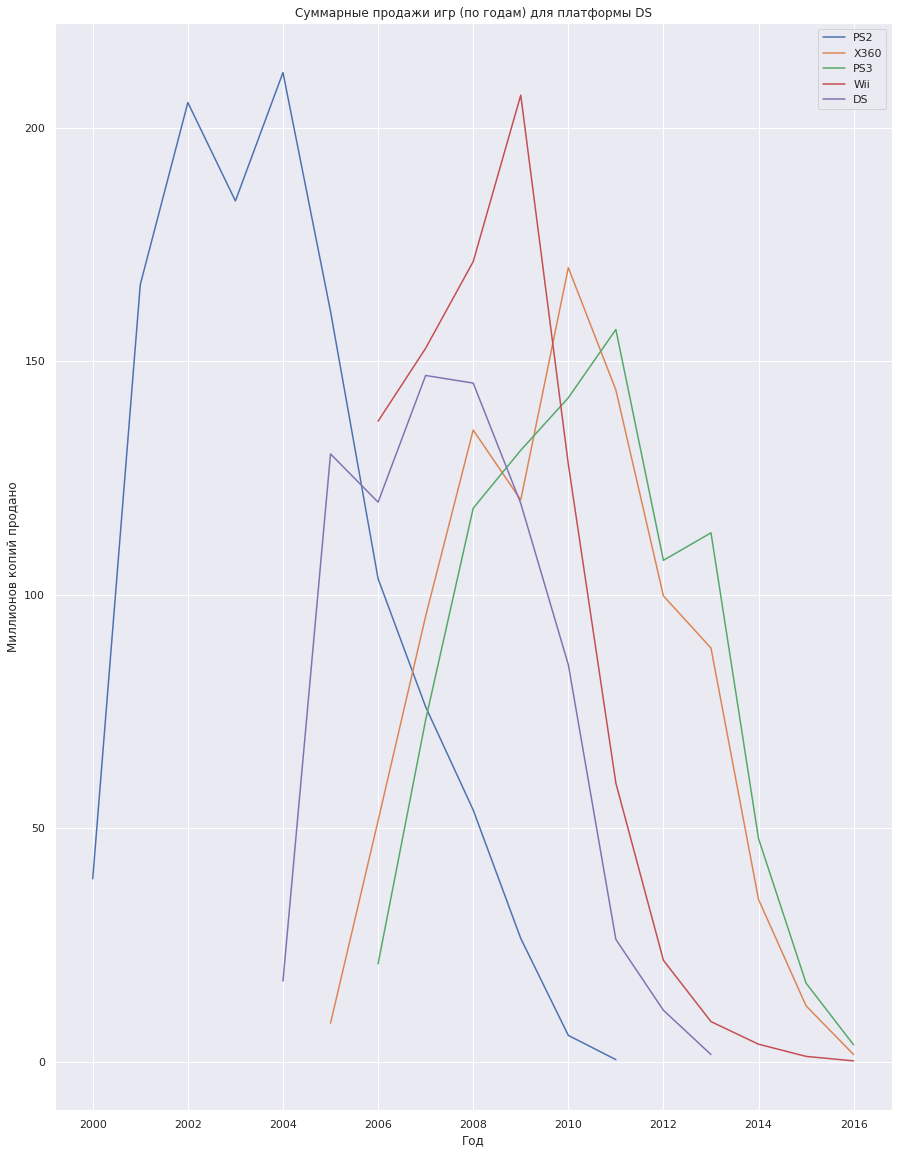

In [48]:
platforms = (
    df
    .pivot_table(index=['platform'], values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=False)
    .index.values.tolist()[:5])

for platform in platforms:
    platform_pivot = (
        df[df['platform'] == platform]
        .pivot_table(index=['year_of_release'], values='total_sales', aggfunc='sum')
    )
    plt.plot(platform_pivot.index, platform_pivot['total_sales'], label=platform)
    #platform_pivot.plot(
    #    style='o-',
    #    use_index=True,
    #    y='total_sales',
    #    figsize=(20,15),
    #    grid=True)
plt.title(f'Суммарные продажи игр (по годам) для платформы {platform}')
plt.xlabel('Год')
plt.ylabel('Миллионов копий продано')
plt.legend(loc='best')
plt.show()    
    #plt.plot(<X AXIS VALUES HERE>, <Y AXIS VALUES HERE>, 'line type', label='label here')
    #plt.plot(<X AXIS VALUES HERE>, <Y AXIS VALUES HERE>, 'line type', label='label here')
    

На графике для Nintendo DS присутствует артефакт - игра, выпущенная в 1985 году. Nintendo DS была выпущена в 2004 году. Взглянем на него:

In [29]:
df[(df['year_of_release'] == 1985) & (df['platform'] == 'DS')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,NaN,NaN,not rated by ESRB,0.02


Многомиллионных продаж он не принёс, поэтому смело удалим его из датасета.

In [30]:
print('Количество строк до удаления', df.shape[0])
df = df.drop(df[(df['year_of_release'] == 1985) & (df['platform'] == 'DS')].index)
print('Количество строк после удаления', df.shape[0])

Количество строк до удаления 16444
Количество строк после удаления 16443


Как видно из графиков, срок жизни платформы может достигать чуть больше 10 лет; однако действительно популярными платформы могут быть только 6-7 лет после выпуска, после которых спрос на видеоигры данной платформы идёт на резкий спад. В целом, можно утверждать, что компании выпускают новые платформы каждые 6-7 лет; в то время как старые исчезают за ~10.

### Срез данных за актуальный период

Возьмём данные за соответствующий актуальный период. Актуальный период определим в результате выводов предыдущих вопросов. Основной фактор — эти данные помогут нам построить прогноз на 2017 год.

Итак, как мы выяснили из 1-го вопроса, текущее состояние дел в индустрии видеоигр отражают данные за 2012 год и далее; плюс, мы выяснили, что 6 лет - life-period популярности новых платформ. Поэтому, возьмём 6-летний период, в котором 2017 год приходится на 6-ой год, т.е. с 2012 года.

In [31]:
df_actual = df[df['year_of_release'] >= 2012]

### Какие платформы лидируют по продажам

Выясним, какие платформы лидируют по продажам, какие растут или падают. Выберем несколько потенциально прибыльных платформ. Используем актуальные данные.

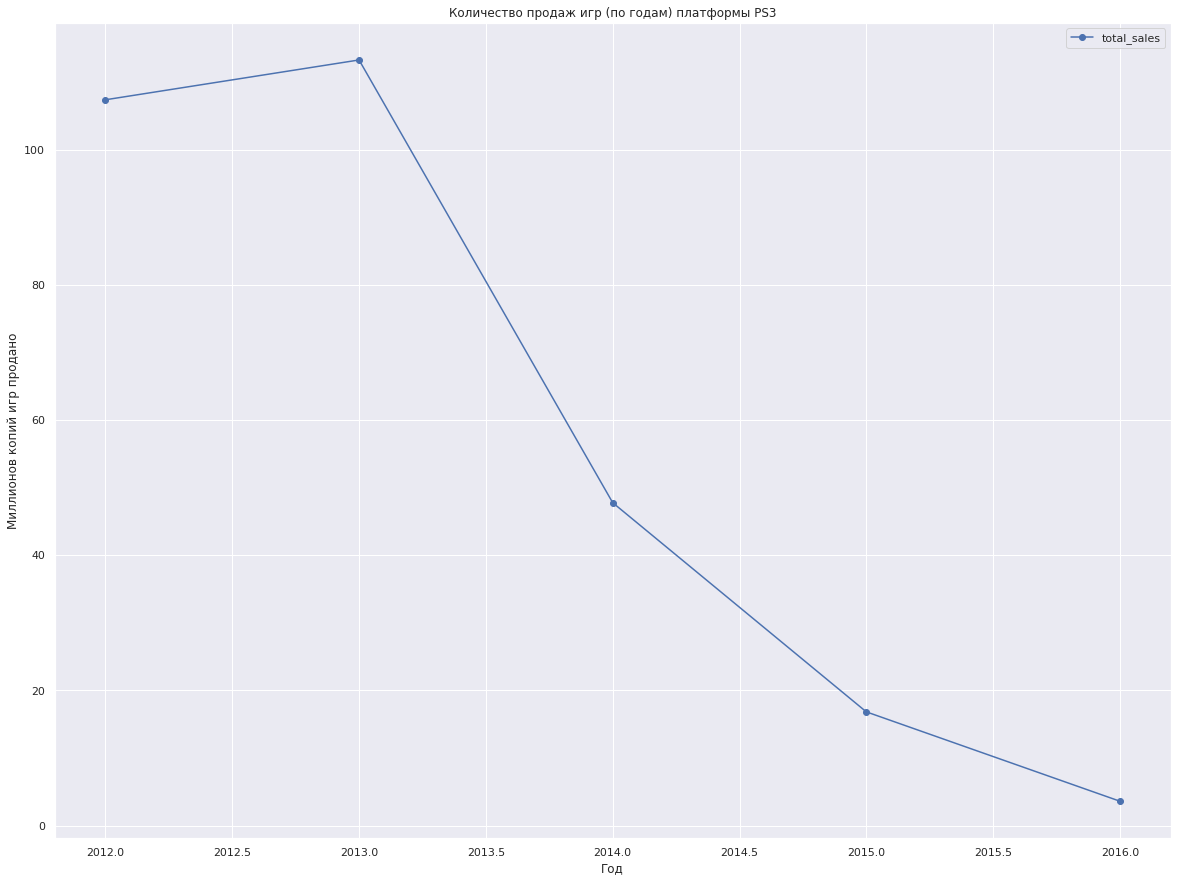

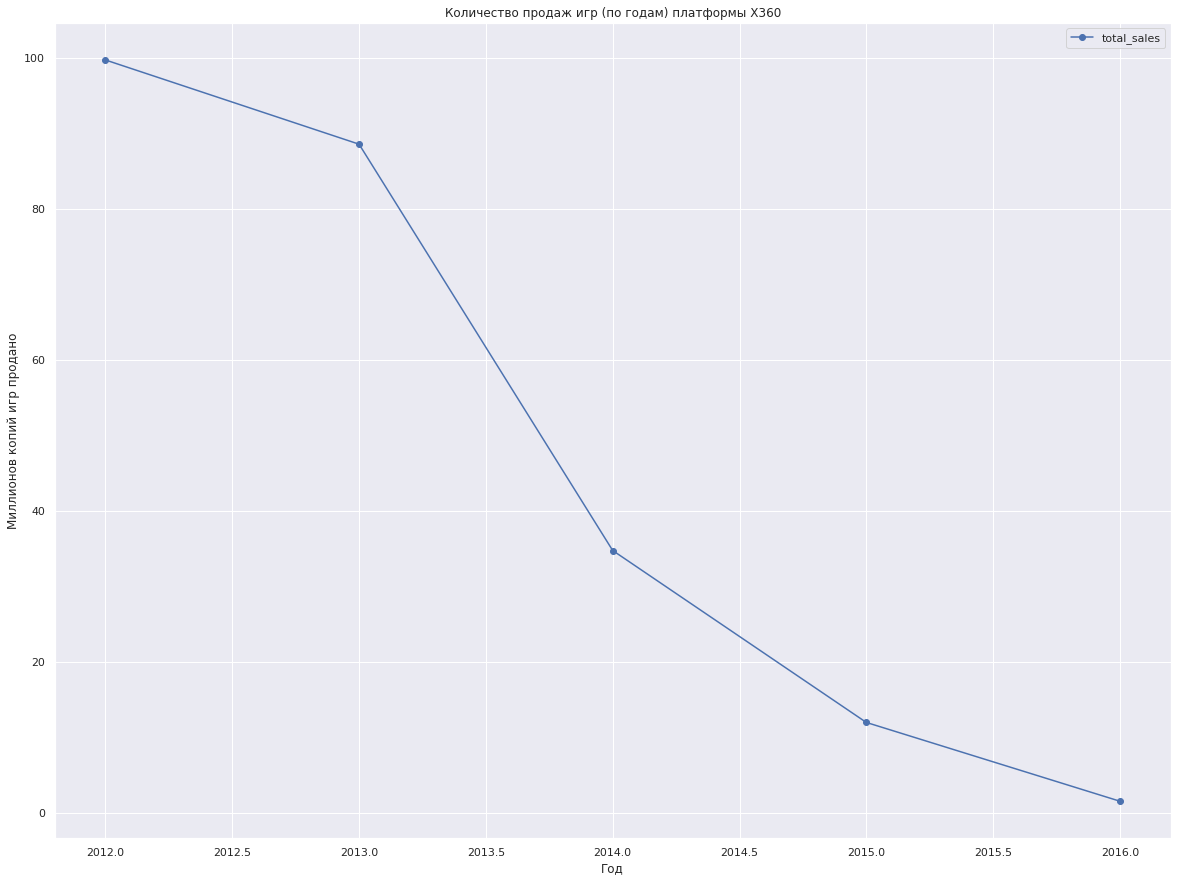

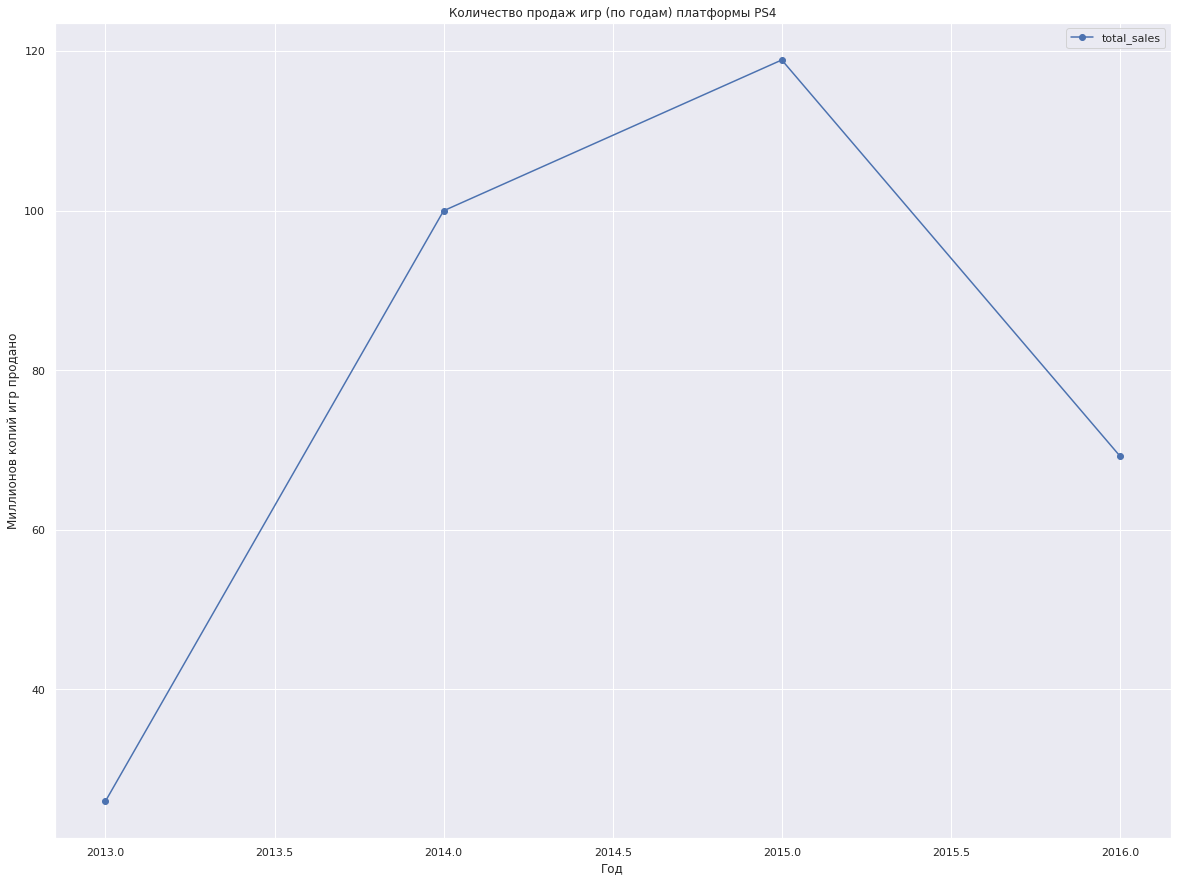

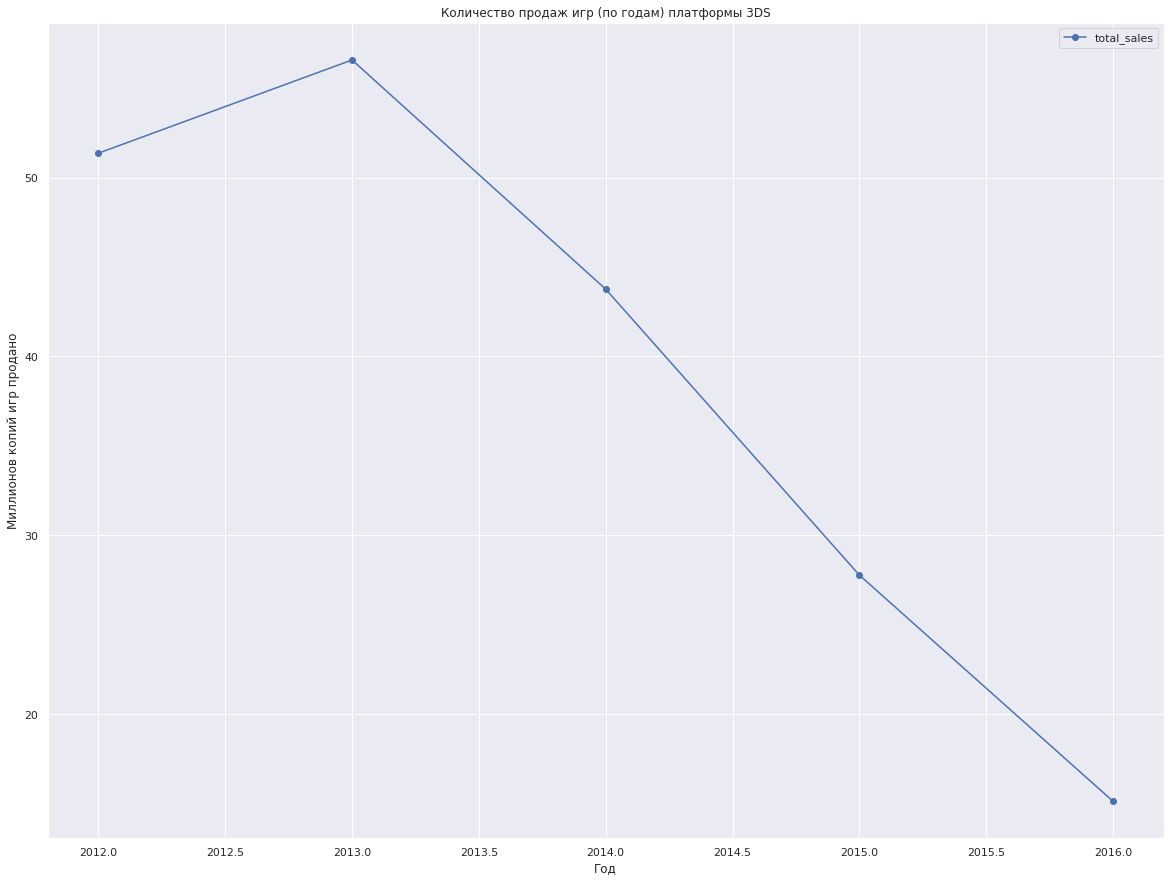

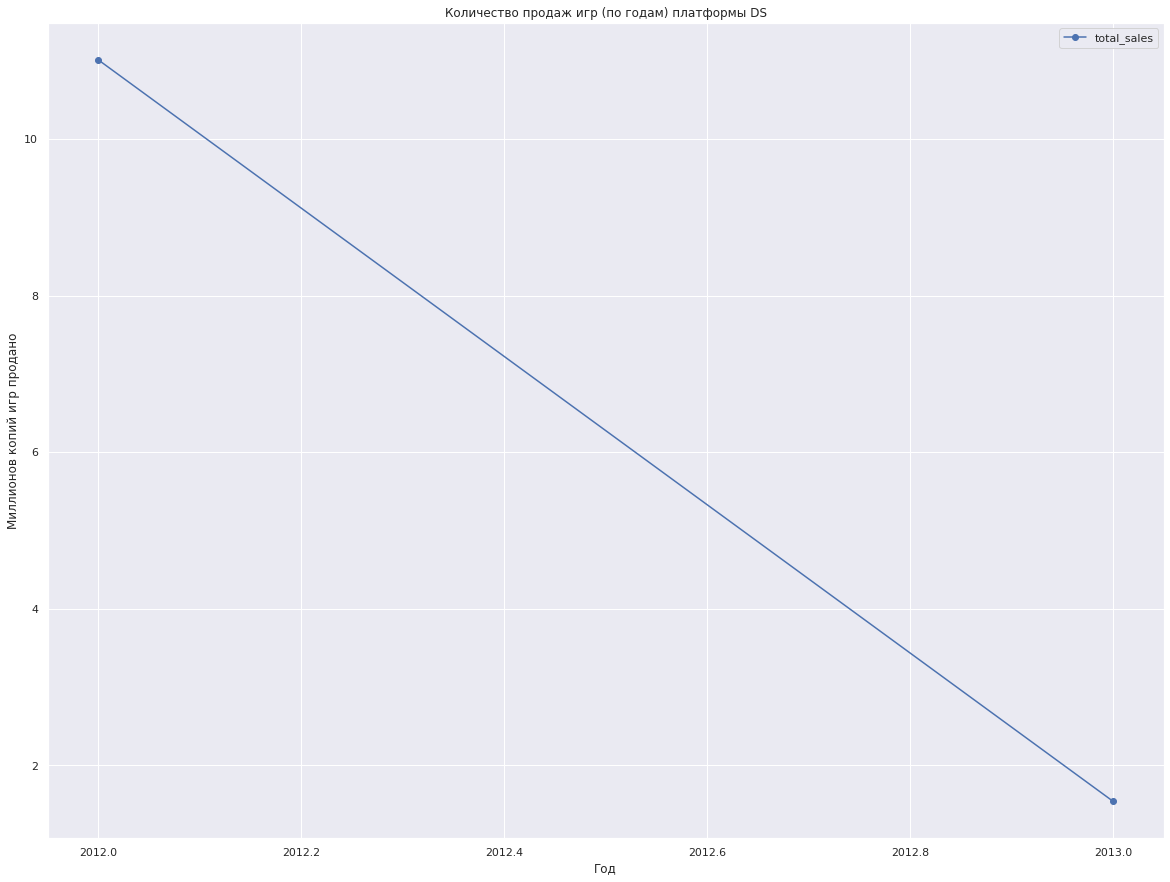

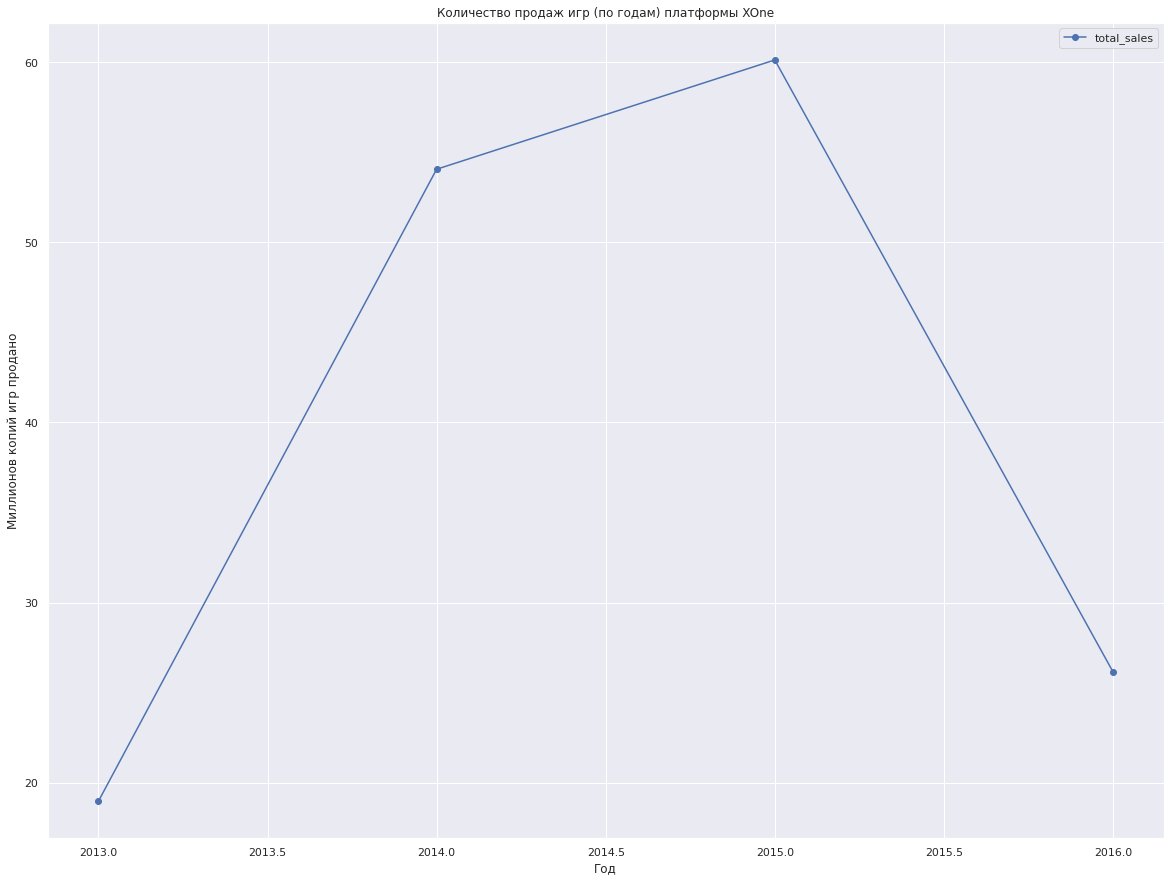

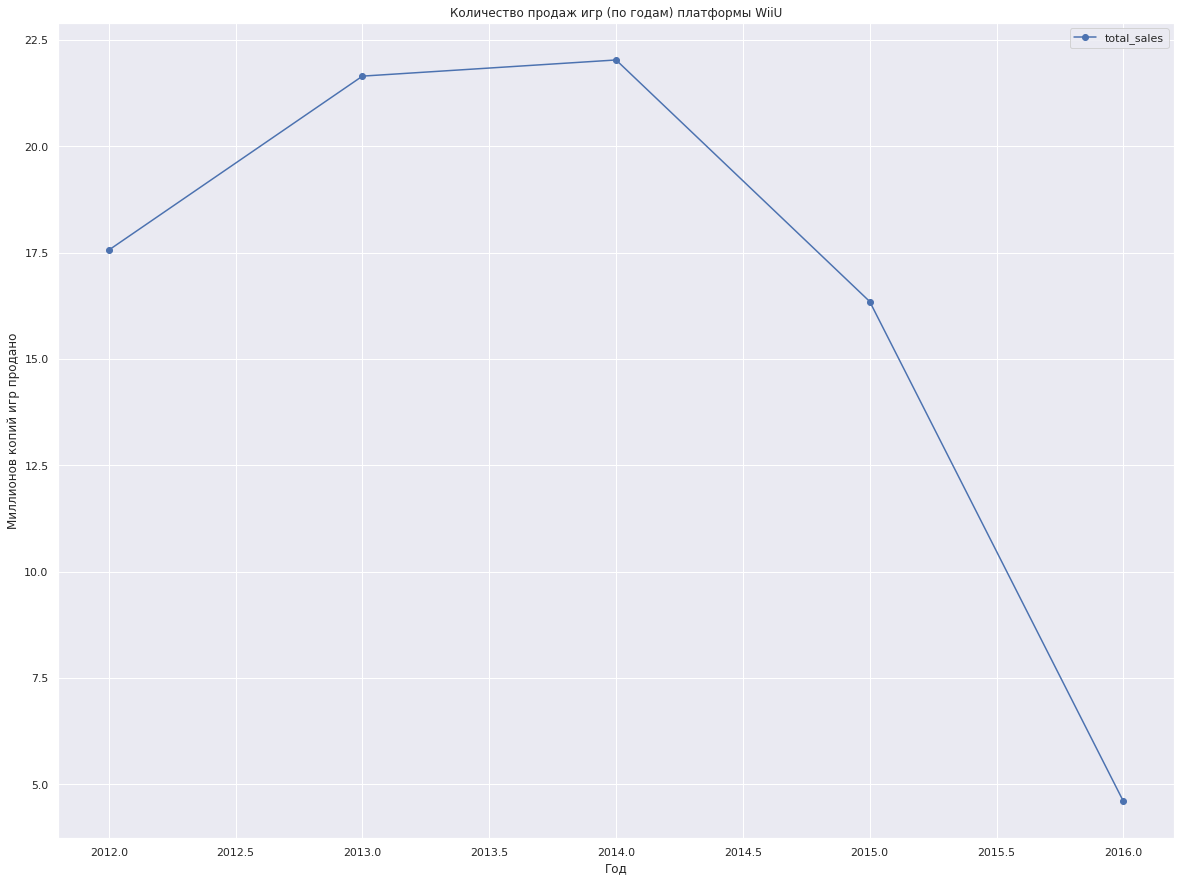

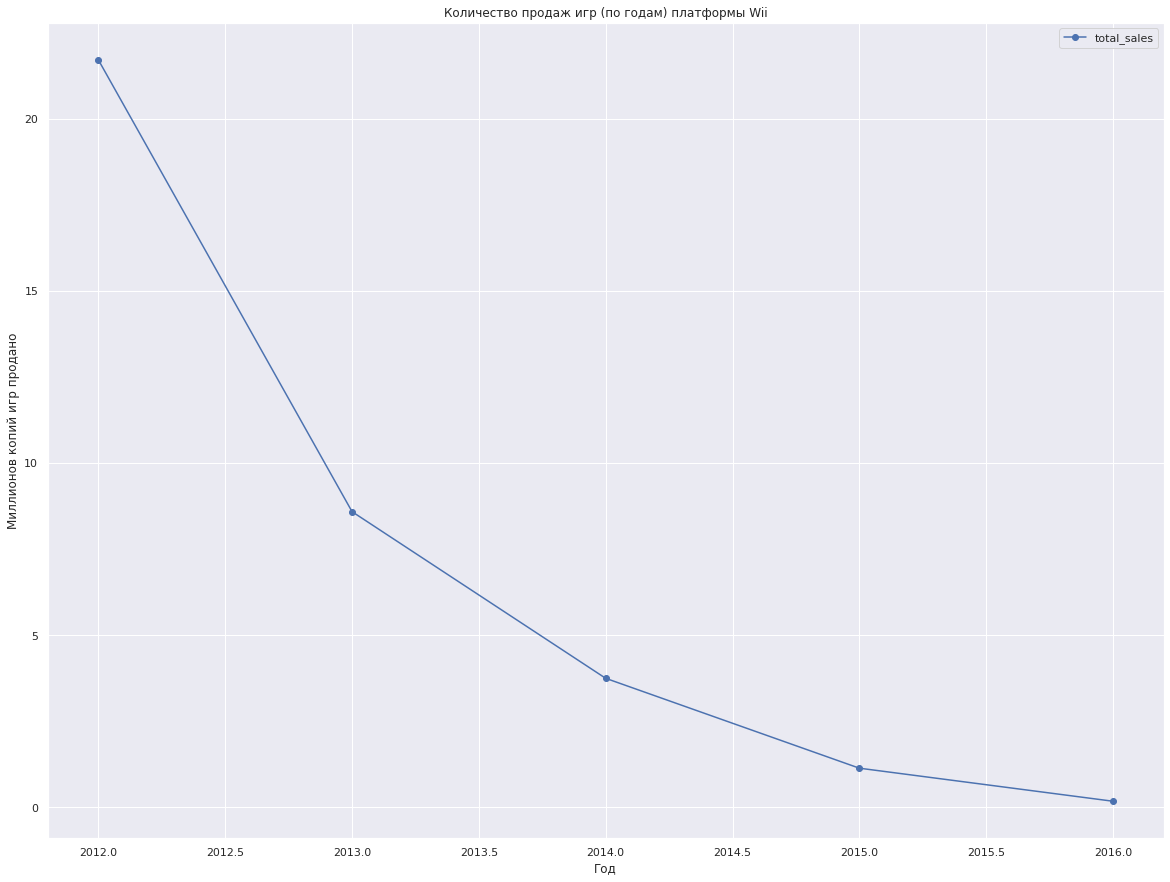

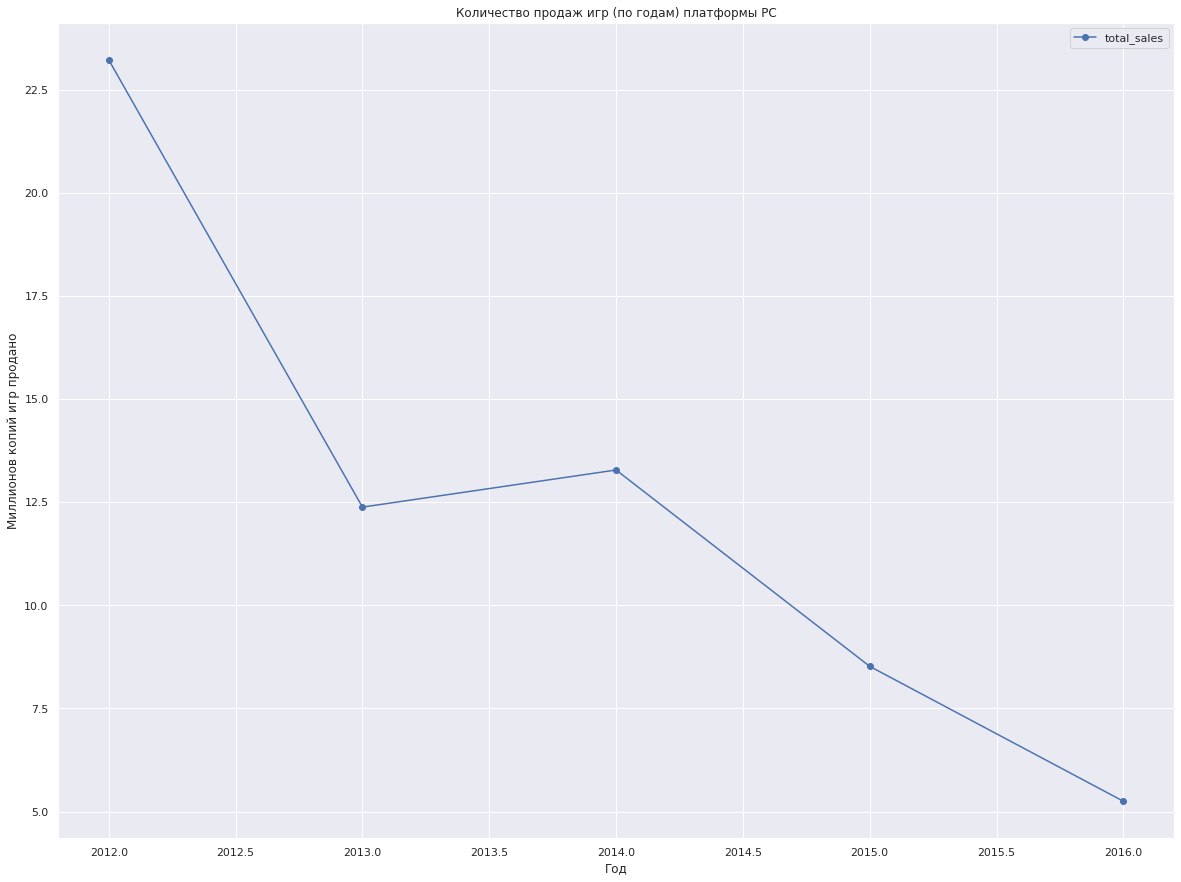

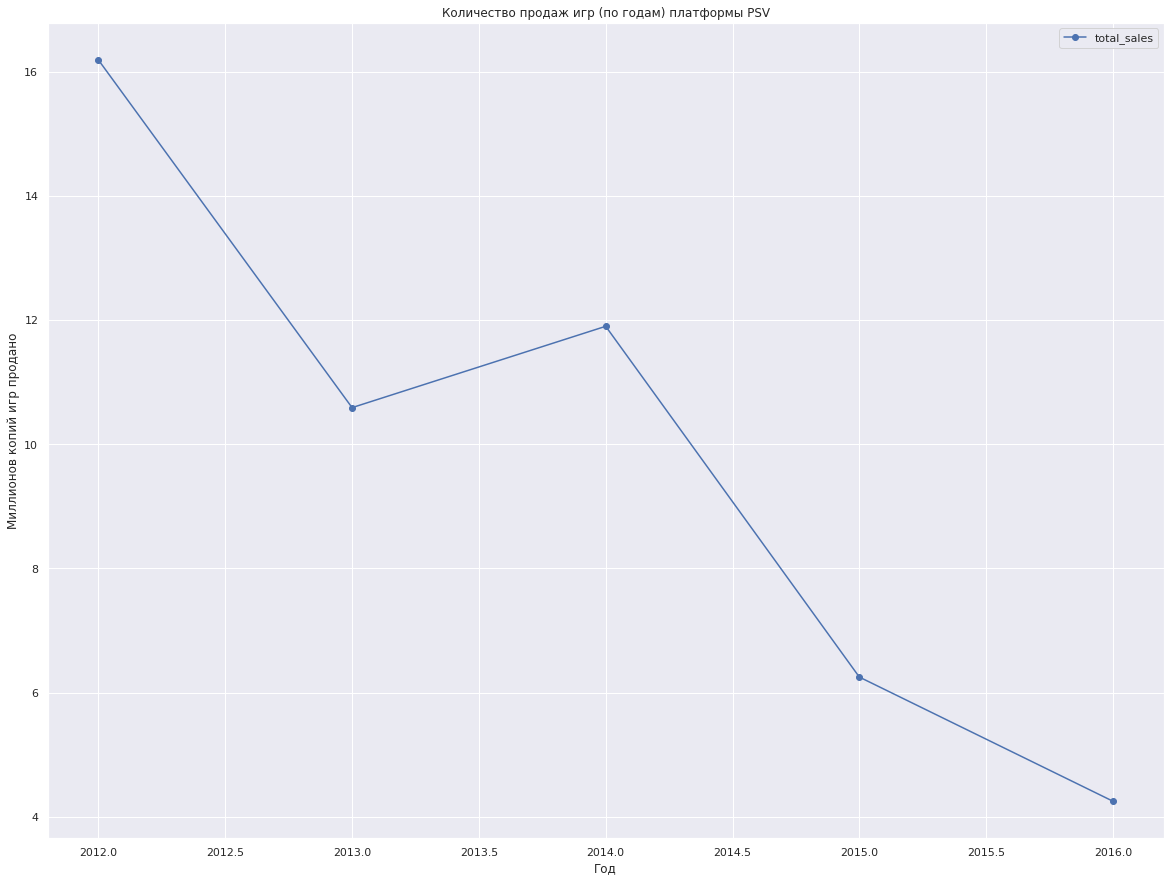

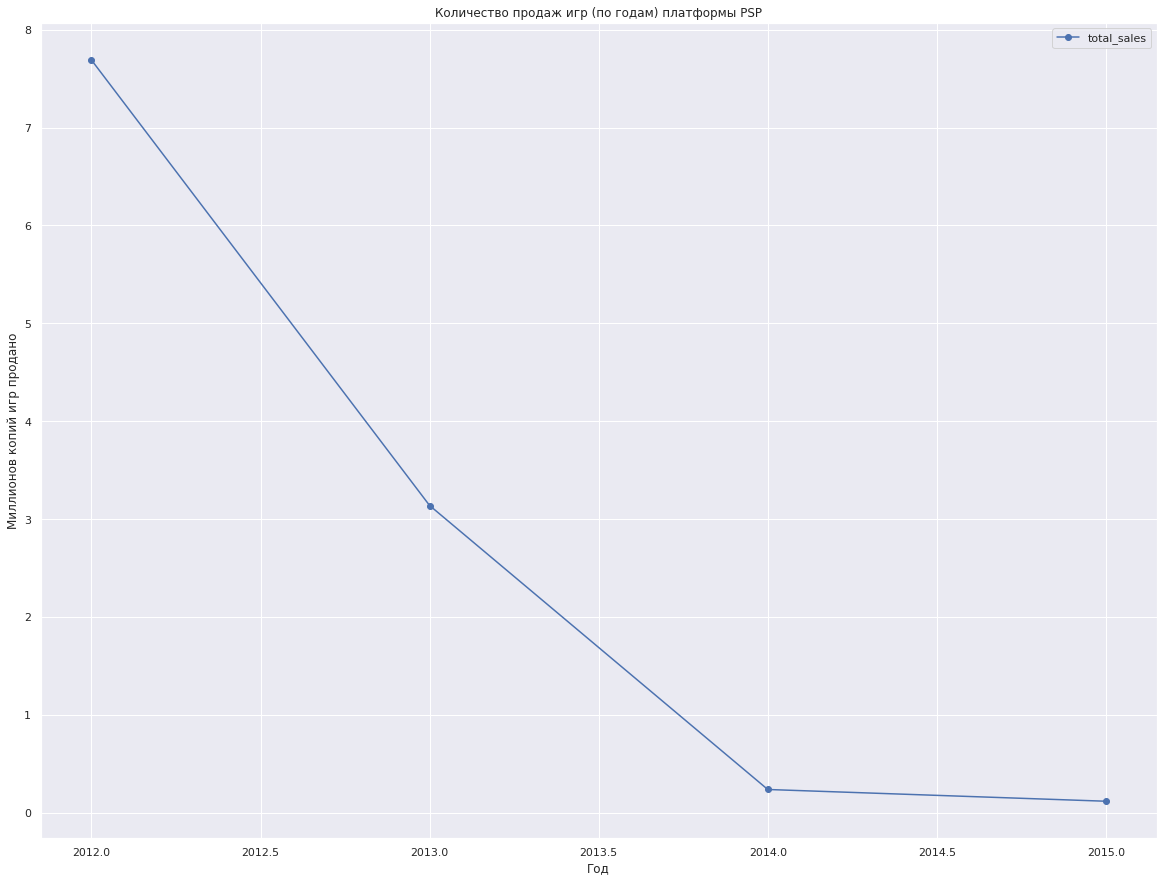

In [32]:
for platform in df_actual['platform'].unique():
    platform_pivot = (
        df_actual[df_actual['platform'] == platform]
        .pivot_table(index=['year_of_release'], values='total_sales', aggfunc='sum')
    )

    platform_pivot.plot(
        style='o-',
        use_index=True,
        y='total_sales',
        figsize=(20,15),
        grid=True)
    plt.title(f'Количество продаж игр (по годам) платформы {platform}')
    plt.xlabel('Год')
    plt.ylabel('Миллионов копий игр продано')
    plt.show()

Сразу следует упомянуть, что данные за 2016 год - неполные, они не отражают актуальной динамики. Будем ориентироваться на данные за 2012-2015 года.

- Популярность Playstation 3 стремительно падает.

- Xbox 360 тоже демонстрирует резкий регресс популярности.

- У Playstation 4 можно заметить резкий рост.

- Nintendo 3DS имеет плавный спад популярности после пиковых первых 2ух лет.

- Для Nintendo DS перестали выпускаться игры в 2013 году.

- Xbox One переживает период популярности, заметный тренд на рост.

- У Nintendo WiiU в целом постоянный (без резких изменений) уровень популярности, который незначительно колеблется.

- Для Nintendo Wii это закат - снижение уровня продаж практически до нуля.

- ПК демонстрирует снижение популярности.

- У PS Vita заметен устойчивый регресс популярности.

- Для PS Portable выпуск игр прекратился в 2015 году.

Потенциально прибыльные платформы: Playstation 4, Xbox One, Nintendo WiiU и Nintendo 3DS.

### График boxplot по глобальным продажам игр в разбивке по платформам

Построим график c «ящиками с усами» по глобальным продажам игр в разбивке по платформам.

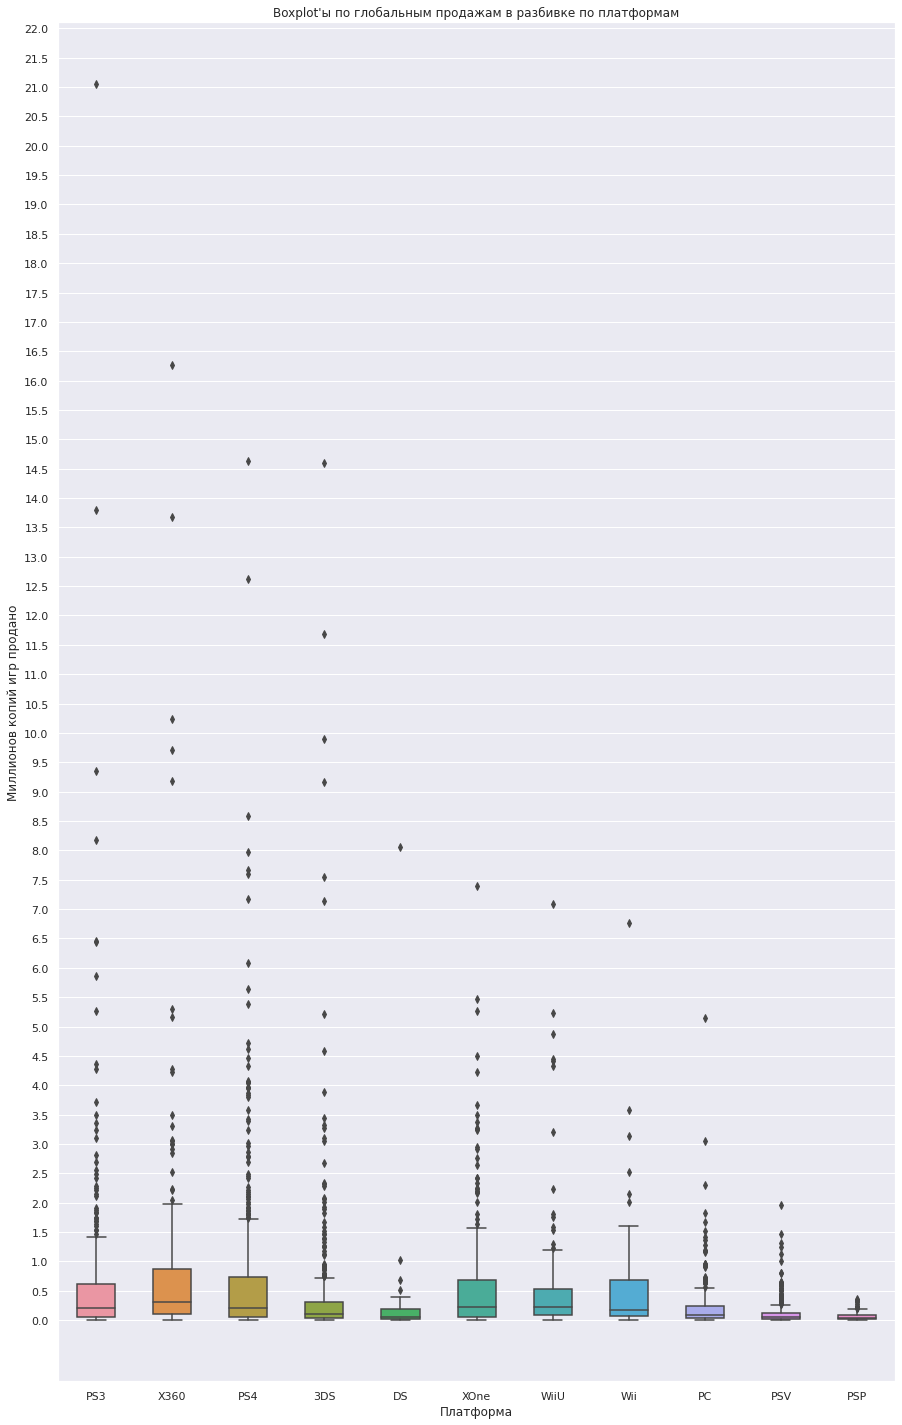

In [33]:
sns.set(rc={'figure.figsize':(15,25)})
ax = sns.boxplot(x='platform', y='total_sales',width = 0.5, data=df_actual)
ax.set_yticks(np.arange(0,22.5,0.5))
plt.title("Boxplot'ы по глобальным продажам в разбивке по платформам")
plt.xlabel('Платформа')
plt.ylabel('Миллионов копий игр продано')
plt.show()

Увеличим масштаб и зададим предел до 2-ух миллионов, чтобы лучше видеть квартили и медианы:

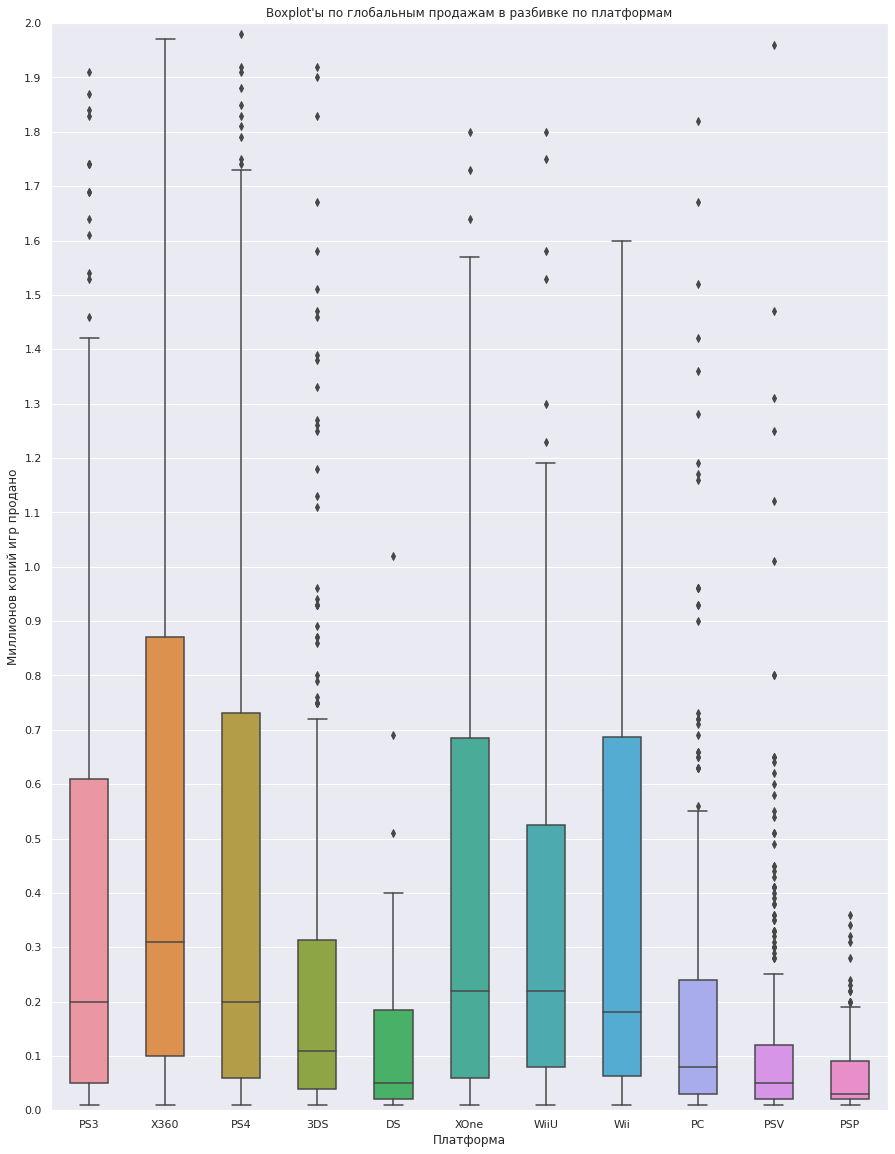

In [34]:
sns.set(rc={'figure.figsize':(15,20)})
ax = sns.boxplot(x='platform', y='total_sales',width = 0.5, data=df_actual)
ax.set_yticks(np.arange(0,2.1,0.1))
ax.set(ylim=(0, 2.0))
plt.title("Boxplot'ы по глобальным продажам в разбивке по платформам")
plt.xlabel('Платформа')
plt.ylabel('Миллионов копий игр продано')
plt.show()

Опишем результаты:
- для Playstation 3 большинство игр продаются 1.4 (и меньше) милионными тиражами, 50% игр продаётся до 200 тыс. копий. Но есть множество выбросов от 1.4 до 4 млн, вплоть до 21-милионных.
- для Xbox 360 большинство игр продаётся тиражами до 2ух миллионов, 50% игр продаётся до 300 тыс. копий; но выбросов здесь существенно меньше и только до 16 млн.
- для Playstation 4 большинство игр продаётся 1.7 млн тиражами, 50% игр продаётся до 200 тыс. копий; очень много выбросов от 2 до 5 млн, вплоть до 14.5 млн.
- для Nintendo 3DS свойственны тиражи игр 700 тыс копий, 50% игр продаётся до 100 тыс. копий; много выбросов от 1 до 4 млн, самый большой - 14.5 млн.
- для Nintendo DS большинство игр были проданы в пределах 400 тыс. копий, 50% игр продаётся до 50 тыс. копий, выбросов почти нет.
- для Xbox One игры продаются в основном в пределах 1.6 млн копий, 50% игр продаётся 220 тыс. копий, некоторое количество выбросов от 1.5 до 3.5 млн, максимум - 7.5 млн.
- для Nintendo WiiU игры продаются 1.2 млн тиражами, 50% игр продаётся до 220 тыс. копий, выбросов мало, максимальный - 7 млн копий.
- для Nintendo Wii игры продаются 1.6 млн тиражами, 50% игр продаётся до 190 тыс. копий, выбросов совсем мало.
- для ПК игры продаются по 550 тыс. копий, 50% игр продаётся до 80 тыс. копий, много выбросов от 500 тыс до 2 млн копий.
- для PS Vita тиражи по сравнению с другими платформами маленькие - 250 тыс копий, 50% игр продаётся до 50 тыс. копий, много выбросов от 250 до 750 тыс.; максимальные - 2 млн.
- для PS Portable тиражи ещё меньше - до 190 тыс копий, 50% игр продаётся до 30 тыс. копий, выбросов очень мало и они до 360 тыс копий.

### Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

В качестве популярной платформы возьмем Playstation 4.

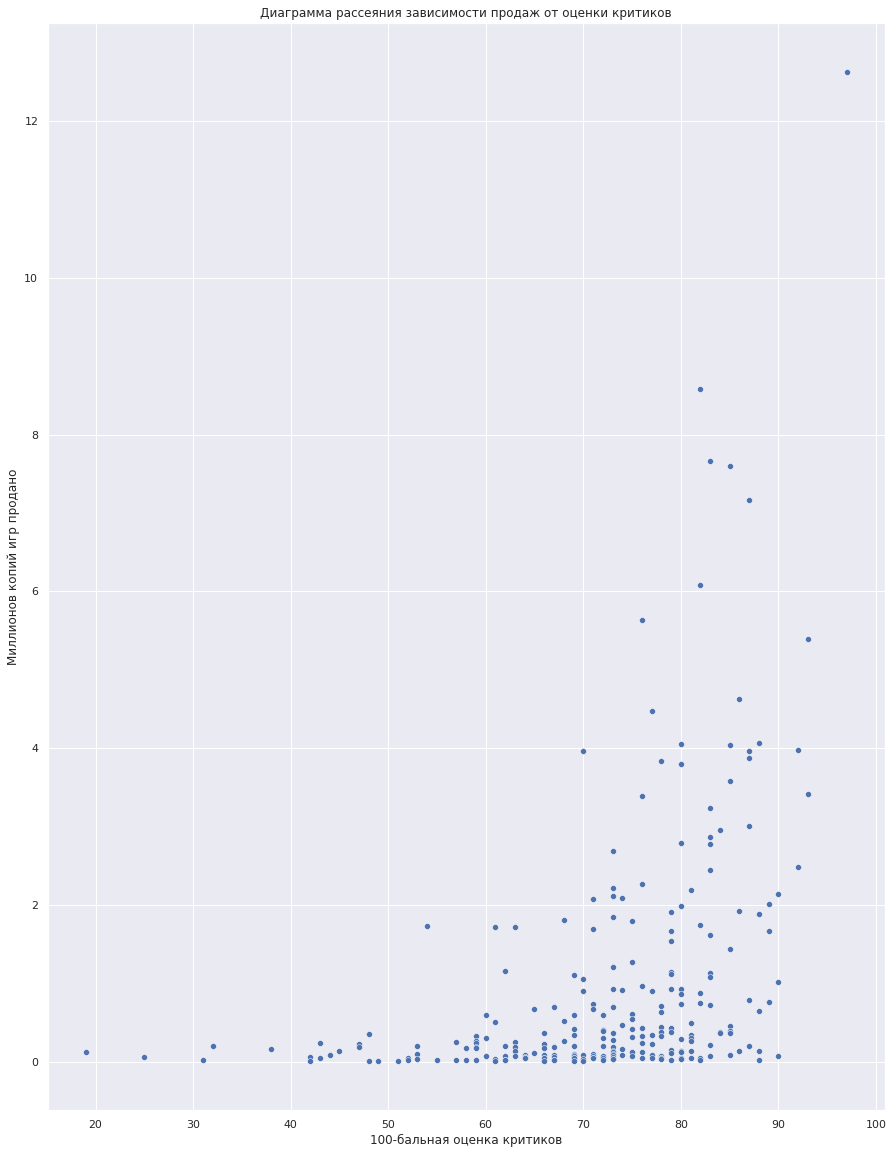

Коэффициент корреляции Пирсона для суммарных продаж и оценки критиков: 0.406567902061781


In [35]:
sns.scatterplot(
    data=df_actual[df_actual['platform'] == 'PS4'], 
    x='critic_score', 
    y='total_sales'
    )
plt.title('Диаграмма рассеяния зависимости продаж от оценки критиков')
plt.xlabel('100-бальная оценка критиков')
plt.ylabel('Миллионов копий игр продано')
plt.show()
print('Коэффициент корреляции Пирсона для суммарных продаж и оценки критиков:',
      df_actual[df_actual['platform'] == 'PS4']['total_sales']
      .corr(df_actual[df_actual['platform'] == 'PS4']['critic_score']))

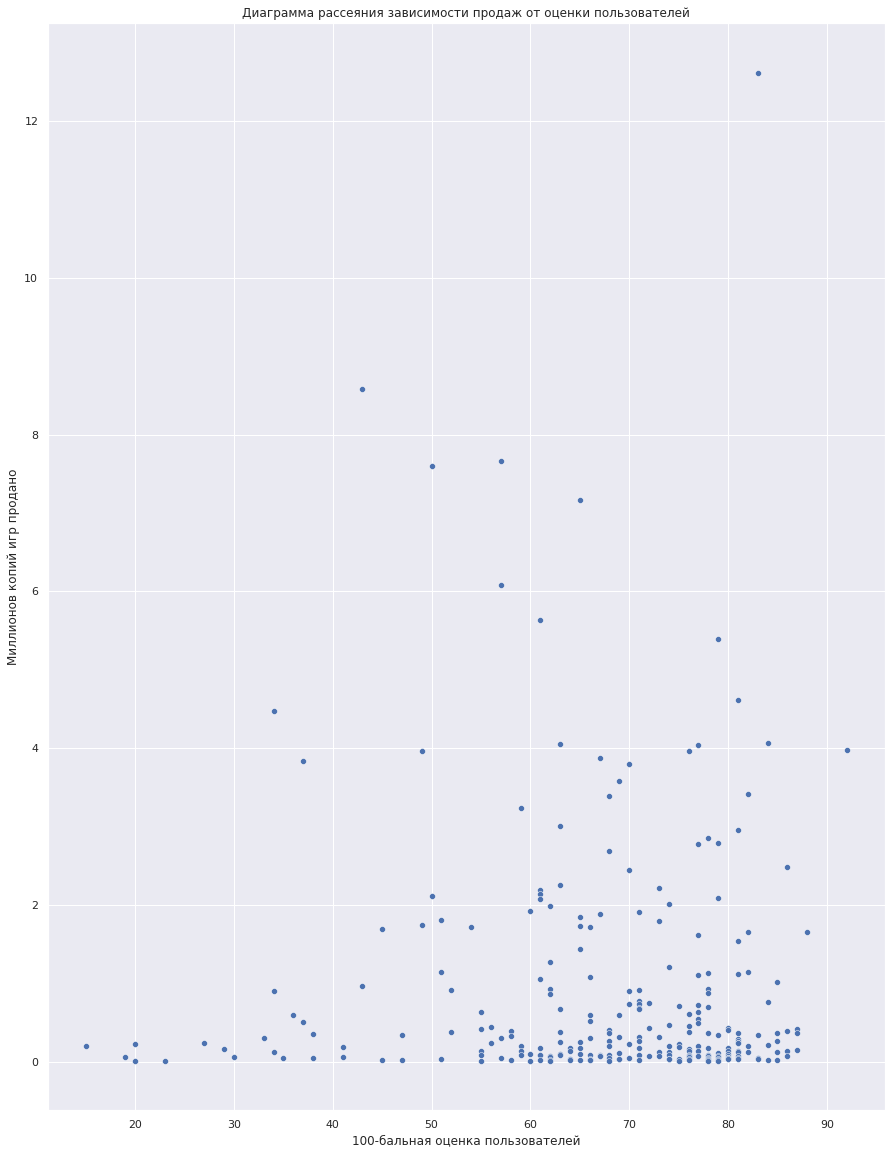

Коэффициент корреляции Пирсона для суммарных продаж и оценки пользователей: -0.03195711020455641


In [36]:
sns.scatterplot(
    data=df_actual[df_actual['platform'] == 'PS4'], 
    x='user_score', 
    y='total_sales'
    )
plt.title('Диаграмма рассеяния зависимости продаж от оценки пользователей')
plt.xlabel('100-бальная оценка пользователей')
plt.ylabel('Миллионов копий игр продано')
plt.show()
print('Коэффициент корреляции Пирсона для суммарных продаж и оценки пользователей:',
      df_actual[df_actual['platform'] == 'PS4']['total_sales']
      .corr(df_actual[df_actual['platform'] == 'PS4']['user_score']))

Как видно из графиков, присутствует корреляция (ниже среднего) между продажами и оценками критиков и никакой корреляции между оценками пользователей и продажами. Данный вывод подтверждают рассчитанные коэффициенты корреляции Пирсона: ~0.4 для продаж и оценкой критиков; ~0 для продаж и оценкой пользователей.

Соотнесём выводы с продажами игр на других платформах.

In [37]:
for platform in df_actual['platform'].unique():
    print('Платформа ', platform)
    print('Коэффициент корреляции Пирсона для суммарных продаж и оценки критиков:',
      df_actual[df_actual['platform'] == platform]['total_sales']
      .corr(df_actual[df_actual['platform'] == platform]['critic_score']))
    print('Всего видеоигр с оценками критиков:',
          df_actual[df_actual['platform'] == platform]['critic_score'].count())
    print('Всего видеоигр без оценок критиков:',
          df_actual[df_actual['platform'] == platform]['critic_score'].isna().sum())
    print('*' * 15)
    
    print('Коэффициент корреляции Пирсона для суммарных продаж и оценки пользователей:',
      df_actual[df_actual['platform'] == platform]['total_sales']
      .corr(df_actual[df_actual['platform'] == platform]['user_score']))
    print('Всего видеоигр с оценками пользователей:',
          df_actual[df_actual['platform'] == platform]['user_score'].count())
    print('Всего видеоигр без оценок пользователей:',
          df_actual[df_actual['platform'] == platform]['user_score'].isna().sum())
    print('-' * 45)

Платформа  PS3
Коэффициент корреляции Пирсона для суммарных продаж и оценки критиков: 0.3314972592629587
Всего видеоигр с оценками критиков: 214
Всего видеоигр без оценок критиков: 279
***************
Коэффициент корреляции Пирсона для суммарных продаж и оценки пользователей: -0.005143522887113775
Всего видеоигр с оценками пользователей: 283
Всего видеоигр без оценок пользователей: 210
---------------------------------------------
Платформа  X360
Коэффициент корреляции Пирсона для суммарных продаж и оценки критиков: 0.36057348885073365
Всего видеоигр с оценками критиков: 171
Всего видеоигр без оценок критиков: 121
***************
Коэффициент корреляции Пирсона для суммарных продаж и оценки пользователей: 0.006163978646213392
Всего видеоигр с оценками пользователей: 235
Всего видеоигр без оценок пользователей: 57
---------------------------------------------
Платформа  PS4
Коэффициент корреляции Пирсона для суммарных продаж и оценки критиков: 0.406567902061781
Всего видеоигр с оценками 

/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


В целом, вышеназванные выводы подтверждаются результатами на других платформах. В данных результатах не будем учитывать платформы с количеством оценок <50, что отсекает Nintendo DS, Nintendo Wii и PS Portable.

Выводы о корреляции ниже среднего между оценкой критиков и продажами и нулевой корреляции между оценками пользователей и продажами подтверждают платформы: Playstation 3, Xbox 360, Nintendo 3DS, Xbox One, Playstation 4.
Частично подтверждают: Nintendo WiiU, PC.
Не подтверждают: PS Vita.

### Общее распределение игр по жанрам

Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [38]:
genre_pivot_table = df_actual.pivot_table(index=['genre'], values='total_sales', aggfunc=['mean', 'sum', 'count'])
genre_pivot_table.sort_values(by=('mean', 'total_sales'), ascending=False)

,mean,sum,count
,total_sales,total_sales,total_sales
genre,,,
Shooter,1.296723,304.73,235
Platform,0.717647,61.00,85
Sports,0.675634,181.07,268
Role-Playing,0.521081,192.80,370
Racing,0.465217,53.50,115
Misc,0.442917,85.04,192
Simulation,0.439000,35.12,80
Action,0.427856,441.12,1031


Самые прибыльные жанры - шутеры (1.3 млн копий в среднем на игру), платформеры (0.71 млн) и спортивные игры (0.68 млн). Большинство жанров демонстрируют продажи в районе от 500 до 400 тыс. копий за игру. Самые низкие продажи имеют стратегии (190 тыс. копий), пазлы (170 тыс.) и адвенчуры (100 тыс.).

---

**Вывод:** в ходе этапа исследовательского анализа данных мы выяснили, что
- в период с 1980 по 1995 года видеоигры не пользовались популярностью; пик выпуска игр пришелся на 2005-2011 годы; начиная с 2012 года игр было выпущено 2 раза меньше, по сравнению с пиком;
- срок жизни платформы может достигать чуть больше 10 лет; однако действительно популярными платформы могут быть только 6-7 лет после выпуска, после которых спрос на видеоигры данной платформы идёт на резкий спад; в целом, можно утверждать, что компании выпускают новые платформы каждые 6-7 лет; в то время как старые исчезают за ~10;
- актуальный период для дальнейшего анализа - это 2012-2016 года;
- потенциально прибыльные платформы: Playstation 4, Xbox One и Nintendo WiiU;
- у большинства платформ большинство игр продаётся тиражами 1-2 млн. копий;
- присутствует взаимосвязь (ниже среднего) между продажами и оценками критиков (корреляция ~0.4) и никакой взаимосвязи между оценками пользователей и продажами (корреляция ~0);
- самые прибыльные жанры - шутеры (1.3 млн копий в среднем на игру), платформеры (0.71 млн) и спортивные игры (0.68 млн); самые низкие продажи имеют стратегии (190 тыс. копий), пазлы (170 тыс.) и адвенчуры (100 тыс.).

## Портрет пользователя каждого региона

### Самые популярные платформы 

Определим для пользователя каждого региона (NA, EU, JP) самые популярные платформы (топ-5). Опишем различия в долях продаж ('share').

In [49]:
regions = {'na_sales':'Северная америка', 'eu_sales':'Европа', 'jp_sales':'Япония'}

for key in regions:
    popular_platform = (
        df_actual
        .pivot_table(
            index=['platform'],
            values=key,
            aggfunc=['mean', 'sum', 'count'])
    )
    popular_platform['share'] = popular_platform[('sum', key)] / popular_platform[('sum', key)].sum()
    print('Популярные платформы в регионе', regions[key])
    display(popular_platform.sort_values(by='share', ascending=False).head())
    print('*' * 40)
    print()

Популярные платформы в регионе Северная америка


,mean,sum,count,share
,na_sales,na_sales,na_sales,
platform,,,,
X360,0.479623,140.05,292,0.236983
PS4,0.277398,108.74,392,0.184003
PS3,0.209696,103.38,493,0.174933
XOne,0.377004,93.12,247,0.157571
3DS,0.139672,55.31,396,0.093592


****************************************

Популярные платформы в регионе Европа


,mean,sum,count,share
,eu_sales,eu_sales,eu_sales,
platform,,,,
PS4,0.359923,141.09,392,0.278383
PS3,0.216755,106.86,493,0.210844
X360,0.255205,74.52,292,0.147034
XOne,0.208866,51.59,247,0.101792
3DS,0.107677,42.64,396,0.084132


****************************************

Популярные платформы в регионе Япония


,mean,sum,count,share
,jp_sales,jp_sales,jp_sales,
platform,,,,
3DS,0.221692,87.79,396,0.455862
PS3,0.071582,35.29,493,0.183249
PSV,0.051192,21.04,411,0.109253
PS4,0.040714,15.96,392,0.082875
WiiU,0.088503,13.01,147,0.067556


****************************************



**Вывод:**
Для пользователей Северной Америки самые популярные платформы: Xbox 360 (24% доля продаж по всему региону), Playstation 4 (18%), Playstation 3 (17%), Xbox One (16%), Nintendo 3DS (9%).

Для пользователей Европы топ популярных платформ такой же, но отличаются доли: Xbox 360 (15%), Playstation 4 (28%), Playstation 3 (21%), Xbox One (10%), Nintendo 3DS (8%).

Для Японии картина разительно отличается: Nintendo 3DS (46%), Playstation 3 (18%), PS Vita (11%), Playstation 4 (8%), Nintendo WiiU (7%).

### Самые популярные жанры

Определим для пользователя каждого региона (NA, EU, JP) самые популярные жанры (топ-5).

In [40]:
regions = {'na_sales':'Северная америка', 'eu_sales':'Европа', 'jp_sales':'Япония'}

for key in regions:
    popular_genre = (
        df_actual
        .pivot_table(
            index=['genre'],
            values=key,
            aggfunc=['mean', 'sum', 'count'])
    )
    popular_genre['share'] = popular_genre[('sum', key)] / popular_genre[('sum', key)].sum()
    print('Популярные жанры в регионе', regions[key])
    display(popular_genre.sort_values(by='share', ascending=False).head())
    print('*' * 40)

Популярные жанры в регионе Северная америка


,mean,sum,count,share
,na_sales,na_sales,na_sales,
genre,,,,
Action,0.172493,177.84,1031,0.300929
Shooter,0.616043,144.77,235,0.244970
Sports,0.304216,81.53,268,0.137960
Role-Playing,0.172973,64.00,370,0.108297
Misc,0.198906,38.19,192,0.064623


****************************************
Популярные жанры в регионе Европа


,mean,sum,count,share
,eu_sales,eu_sales,eu_sales,
genre,,,,
Action,0.154549,159.34,1031,0.314392
Shooter,0.482851,113.47,235,0.223886
Sports,0.257799,69.09,268,0.136321
Role-Playing,0.131162,48.53,370,0.095754
Racing,0.237304,27.29,115,0.053846


****************************************
Популярные жанры в регионе Япония


,mean,sum,count,share
,jp_sales,jp_sales,jp_sales,
genre,,,,
Role-Playing,0.176865,65.44,370,0.339807
Action,0.051212,52.80,1031,0.274172
Misc,0.066979,12.86,192,0.066777
Simulation,0.130125,10.41,80,0.054055
Fighting,0.086606,9.44,109,0.049019


****************************************


**Вывод:** Для пользователей Северной Америки самые популярные жанры: экшены (30% доля от всех проданных игр в регионе), шутеры (25%), спортивные игры (14%), ролевые (11%) и с жанром "другое" (6%).

Для Европы ситуация схожа: экшены (31%), шутеры (22%), спортивные игры (14%), ролевые (10%) и гонки (5%).

У Японии совершенно другой топ-5: ролевые (34%), экшены (27%), "другое" (7%), симуляторы (5%), файтинги (5%).

### Влияет ли рейтинг ESRB на продажи в отдельном регионе

Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [41]:
regions = {'na_sales':'Северная америка', 'eu_sales':'Европа', 'jp_sales':'Япония'}

for key in regions:
    rating_sales = (
        df_actual
        .pivot_table(
            index=['rating'],
            values=key,
            aggfunc=['mean', 'sum', 'count'])
    )
    rating_sales['share'] = rating_sales[('sum', key)] / rating_sales[('sum', key)].sum()
    print('Продажи, сгрупированные по рейтингу в регионе', regions[key])
    display(rating_sales.sort_values(by='share', ascending=False))
    print('*' * 40)

Продажи, сгрупированные по рейтингу в регионе Северная америка


,mean,sum,count,share
,na_sales,na_sales,na_sales,
rating,,,,
M,0.465000,231.57,498,0.391847
E,0.289544,114.37,395,0.193529
not rated by ESRB,0.081027,103.31,1275,0.174814
E10+,0.247386,75.70,306,0.128094
T,0.160243,66.02,412,0.111715


****************************************
Продажи, сгрупированные по рейтингу в регионе Европа


,mean,sum,count,share
,eu_sales,eu_sales,eu_sales,
rating,,,,
M,0.389478,193.96,498,0.382700
E,0.286152,113.03,395,0.223018
not rated by ESRB,0.071765,91.50,1275,0.180537
E10+,0.180948,55.37,306,0.109250
T,0.128544,52.96,412,0.104495


****************************************
Продажи, сгрупированные по рейтингу в регионе Япония


,mean,sum,count,share
,jp_sales,jp_sales,jp_sales,
rating,,,,
not rated by ESRB,0.085365,108.84,1275,0.565168
E,0.071722,28.33,395,0.147108
T,0.063155,26.02,412,0.135113
M,0.042570,21.20,498,0.110084
E10+,0.026765,8.19,306,0.042528


****************************************


Справка по возрастным рейтингам:
- E (Everyone) - «Для всех»;
- E10+ (Everyone 10 and older) - «Для всех от 10 лет и старше»;
- T (Teen) - «Подросткам»: игра подходит для лиц от 13 лет;
- M (Mature) - «Для взрослых»: материалы игры не подходят для лиц младше 17 лет;
- not rated by ESRB: по игре отсутствуют данные рейтинга - либо по техническим причинам, либо по причинам того, что игра оценивалась японским (CERO) или европейским (PEGI) рейтинговым агентством, а не американским ESRB.

**Вывод:** да, возрастной рейтинг влияет на продажи в регионах.
В Европе и Северной Америке доминирует портрет взрослого пользователя (39% для Америки и 38% для Европы доля всех проданных игр с рейтингом "Mature" (от 17 лет)), судя по популярности игр с рейтингом M; затем на втором месте игры "для всех" (E) - 19% и 22% соответственно. По 18% доли для игр без рейтинга ESRB. В общем, доли суммарно проданных игр существенно отличаются друг от друга. 

В Японии же, мы не можем сделать выводы по возрастному рейтингу - поскольку 57% всех проданных копий игр приходится на игры без рейтинга ESRB. Это может быть объяснено тем фактом, что японские пользователи в большинстве своём покупают игры, выпущенные для внутреннего рынка Японии - и они оценены японским же агентством CERO.

## Проверка гипотез

Проверим гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Сформулируем:

```
H_0: Средний пользовательский рейтинг (user_score) платформы "XOne" = средний пользовательский рейтинг (user_score) платформы "PC"
H_a: Средний пользовательский рейтинг (user_score) платформы "XOne" ≠ средний пользовательский рейтинг (user_score) платформы "PC"
alpha = 0.05
```

In [42]:
results = st.ttest_ind(
    df_actual[df_actual['platform'] == 'XOne']['user_score'].dropna(),
    df_actual[df_actual['platform'] == 'PC']['user_score'].dropna(),
    equal_var=False) 

alpha = 0.05 

print(results.pvalue)

if results.pvalue < alpha : 
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.5489537965135056
Не получилось отвергнуть нулевую гипотезу


**Статистический вывод:** на имеющихся данных, на уровне значимости 5% (уровне доверия 95%) нет оснований утверждать, что средние пользовательские рейтинги платформ Xbox One и PC значимо различаются.

---

Проверим гипотезу, что средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные. Сформулируем:

```
H_0: Средний пользовательский рейтинг (user_score) жанра "Action" = средний пользовательский рейтинг (user_score) жанра "Sports"
H_a: Средний пользовательский рейтинг (user_score) жанра "Action" ≠ средний пользовательский рейтинг (user_score) жанра "Sports"
alpha = 0.05
```

In [43]:
results = st.ttest_ind(
    df_actual[df_actual['genre'] == 'Action']['user_score'].dropna(),
    df_actual[df_actual['genre'] == 'Sports']['user_score'].dropna(),
    equal_var=False) 

alpha = 0.05 

print(results.pvalue)

if results.pvalue < alpha : 
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

4.243077765726105e-20
Отвергаем нулевую гипотезу


**Статистический вывод:** на имеющихся данных, на уровне значимости 5% (уровне доверия 95%) есть основания утверждать, что средние пользовательские рейтинги жанров Action и Sports различаются.

## Общий вывод

В ходе этапа **предобработки данных** мы:

- привели названия всех столбцов к единому формату;
- изменили тип данных столбца `year_of_release` на datetime и `user_score` на float;
- удалили срез данных с пропусками в `year_of_release`;
- заменили все значения `user_score` с tbd на NaN, поскольку это не меняет общего смысла данных;
- изучили характер пропусков и выяснили, что они обусловлены качеством открытых источников, откуда были взяты исходные данные;
- приняли решение не заполнять пропуски в столбцах `critic_score`, `user_score`, поскольку это исказило бы общее качество данных;
- поставили заглушку в столбец `rating`;
- осуществили поиск явных и неявных дубликатов;
- добавили новый столбец суммарных продаж - `total_sales`.

В ходе этапа **исследовательского анализа данных** мы выяснили, что:

- в период с 1980 по 1990 год видеоигры не пользовались популярностью, расцвет пришёлся на 1990-2000 года; золотым периодом были 2000-2008 года; а период упадка пришёлся на 2009-2014 года; с 2015 года зафиксирован рост;
- срок жизни платформы может достигать чуть больше 10 лет; однако действительно популярными платформы могут быть только 6-7 лет после выпуска, после которых спрос на видеоигры данной платформы идёт на резкий спад; в целом, можно утверждать, что компании выпускают новые платформы каждые 6-7 лет; в то время как старые исчезают за ~10;
- актуальный период для дальнейшего анализа - это 2012-2016 года;
- потенциально прибыльные платформы: Playstation 4, Xbox One, Nintendo WiiU и Nintendo 3DS;
- у большинства платформ подавляющее большинство игр продаётся тиражами до 1-1.8 млн. копий, а медианой является тираж в 200 тыс. копий ;
- присутствует линейная взаимосвязь (ниже среднего) между продажами и оценками критиков (корреляция ~0.4) и никакой взаимосвязи между оценками пользователей и продажами (корреляция ~0);
- самые прибыльные жанры - шутеры (1.3 млн копий в среднем на игру), платформеры (0.71 млн) и спортивные игры (0.68 млн); самые низкие продажи имеют стратегии (190 тыс. копий), пазлы (170 тыс.) и адвенчуры (100 тыс.).

В ходе определения **портрета пользователя** каждого региона мы узнали, что:

- для пользователей Северной Америки самые популярные платформы: Xbox 360 (24% доля продаж по всему региону), Playstation 4 (18%), Playstation 3 (17%), Xbox One (16%), Nintendo 3DS (9%); а жанры: экшены (30% доля от всех проданных игр в регионе), шутеры (25%), спортивные игры (14%), ролевые (11%) и с жанром "другое" (6%).

- для пользователей Европы топ популярных платформ: Xbox 360 (15%), Playstation 4 (28%), Playstation 3 (21%), Xbox One (10%), Nintendo 3DS (8%); а жанров: экшены (31%), шутеры (22%), спортивные игры (14%), ролевые (10%) и гонки (5%).

- для пользователей Японии топ-5 платформ: Nintendo 3DS (46%), Playstation 3 (18%), PS Vita (11%), Playstation 4 (8%), Nintendo WiiU (7%); а жанров: ролевые (34%), экшены (27%), "другое" (7%), симуляторы (5%), файтинги (5%).

- возрастной рейтинг влияет на продажи в регионах Европа и Северная Америка: в них доминирует портрет взрослого пользователя (38% доля всех проданных игр с рейтингом "Mature" (от 17 лет) и в том и в другом регионе); по поводу  Японии сложно сделать вывод, поскольку 57% всех проданных копий игр приходится на игры без рейтинга ESRB. Это может быть объяснено тем фактом, что японские пользователи в большинстве своём покупают игры, выпущенные для внутреннего рынка Японии - и они оценены японским же агентством CERO.

В ходе этапа **проверки гипотез** мы определили:
- у нас нет оснований утверждать, что средние пользовательские рейтинги платформ Xbox One и PC значимо различаются;
- у нас есть основания утверждать, что средние пользовательские рейтинги жанров Action и Sports различаются.
---
**Подытожим** и ответим на первоначальный вопрос по "потенциально популярным продуктам в 2017 году" и как спланировать рекламные кампании в 2017 году:
- для региона Северная Америка и Европа рекомендуется выбрать:
    * платформы Playstation 4 и Xbox One как наиболее популярные;
    * жанры шутеры (как наиболее прибыльные) и спортивные игры (несмотря на то, что доля суммарных продаж экшенов выше, спортивные игры в среднем прибыльнее);
    * с возрастным рейтингом Mature по ESRB;
    * имеет смысл обращать внимание на рейтинги критиков, но не игроков;
- для региона Япония рекомендуется выбрать:
    * платформы Playstation 4 и Nintendo 3DS как наиболее популярные;
    * жанры ролевые (как наиболее прибыльные) и симуляторы (второе место по прибыльности);
    * мы ничего не можем утверждать по поводу возрастного рейтинга ESRB, поскольку в Японии игры оцениваются другим рейтинговым агентством CERO;
    * имеет смысл обращать внимание на рейтинги критиков, но не игроков.
